# Performance of CITE-seq antibodies

- In this notebook density plots are generated from CLR normalized ADT counts 
- For comparisons, signals of NK cell markers are compared between NK and B cells, and between NK cells and isotype controls (available for Neurips dataset).

### Dataset:
- Neurips

### Used NK cell markers are selected based on recent papers and documentation of Mustjoki group; 

- Pfefferle, A., et al. (2019). A Temporal Transcriptional Map of Human Natural Killer Cell Differentiation. BioRxiv, 630657. https://doi.org/10.1101/630657
- Melsen, J. E., et al. (2022). Single-cell transcriptomics in bone marrow delineates CD56dimGranzymeK+ subset as intermediate stage in NK cell differentiation. Frontiers in immunology, 13, 1044398. https://doi.org/10.3389/fimmu.2022.1044398
- Yang, C., et al.(2019). Heterogeneity of human bone marrow and blood natural killer cells defined by single-cell transcriptome. Nature communications, 10(1), 3931. https://doi.org/10.1038/s41467-019-11947-7



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot

import warnings

warnings.filterwarnings('ignore')



Global seed set to 0
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/Users/tiinatuononen/opt/anaconda3/envs/tiina-env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [38]:
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=120, dpi_save=300, vector_friendly=True)

## File preparations

### Neurips

In [3]:
#Neurips

adata_neurips = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

In [4]:
adata_neurips

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [5]:
#Select only NK cells

neurips_nk = adata_neurips[(adata_neurips.obs['cell_type'] == "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]

In [6]:
neurips_nk

View of AnnData object with n_obs × n_vars = 7388 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [7]:
neurips_nk.obs['cell_type'].unique().tolist()

['NK', 'NK CD158e1+']

In [8]:
#saving CLR normalized protein information

neurips_nk_prot=neurips_nk.obsm['protein_expression_clr_neurips']

In [9]:
neurips_nk_prot.shape

(7388, 139)

In [10]:
#To exclude columns that contain only zeros

neurips_nk_prot = pd.DataFrame(neurips_nk_prot)
neurips_nk_prot != 0
(neurips_nk_prot != 0).any(axis=0)
neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]
neurips_nk_prot = neurips_nk_prot.loc[:, (neurips_nk_prot != 0).any(axis=0)]


In [11]:
neurips_nk_prot.shape

(7388, 134)

## Comparisons

In [15]:
#Surface protein markers for NK cells

nk_all = ['CD52',
 'CD127',
 'CD226',
 'CD335',
 'CD195',
 'CD56',
 'CD5',
 'CD69',
 'CD94',
 'CD16',
 'CD122',
 'CD57',
 'CD38',
 'CD158e1',
 'CD34',
 'TIGIT',
 'CD314',
 'CD7',
 'CD62L',
 'CD2',
 'CD27',
 'CX3CR1',
 'CD161',
 'CD155',
 'CD158b']

## Neurips

In [16]:
#check which markers were used in dataset

listOfmarkers= nk_all

nk_neu = []

for x in listOfmarkers:
    if x in neurips_nk_prot.columns:
        nk_neu.append(x)



In [23]:
nk_neu

['CD52',
 'CD127',
 'CD226',
 'CD335',
 'CD195',
 'CD56',
 'CD5',
 'CD69',
 'CD94',
 'CD16',
 'CD122',
 'CD57',
 'CD38',
 'CD158e1',
 'TIGIT',
 'CD314',
 'CD7',
 'CD62L',
 'CD2',
 'CD27',
 'CX3CR1',
 'CD161',
 'CD155',
 'CD158b']

In [24]:
#Sample names
samples=adata_neurips.obs['POOL'].unique().tolist()

In [25]:
#saving protein expression in NK cells into a list

list_prot_nk=[]

for sample in samples:
    eg=adata_neurips[(adata_neurips.obs['cell_type'] ==  "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_neurips']
    prot_marker=prot[nk_neu]
    list_prot_nk.append(prot_marker)
    

In [26]:
#Adding cell type information after sample name

string= " NK cells"

samples_nk = [x + string for x in samples]

In [27]:
#Adding sample names

list_neurips=[]

for i in range(len(list_prot_nk)):
    sample= list_prot_nk[i]
    sample["Sample"]=samples_nk[i]
    list_neurips.append(sample)
    
#creating df

df_nk=pd.concat(list_neurips, axis=0)

In [28]:
#selecting B cells

neurips_b=adata_neurips[adata_neurips.obs['cell_type'] == 'Naive CD20+ B IGKC+']

In [29]:
#saving protein counts in B cells into a list

list_prot_b=[]

for sample in samples:
    eg=adata_neurips[adata_neurips.obs['cell_type'] == 'Naive CD20+ B IGKC+']
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['protein_expression_clr_neurips']
    prot_marker=prot[nk_neu]
    list_prot_b.append(prot_marker)

In [30]:
#Adding cell type information to sample names

string= " B cells"

samples_b = [x + string for x in samples]

In [31]:
#Adding sample names

list_neurips_b=[]

for i in range(len(list_prot_b)):
    sample= list_prot_b[i]
    sample["Sample"]=samples_b[i]
    list_neurips_b.append(sample)
    
#creating df
    
df_b=pd.concat(list_neurips_b, axis=0)

In [32]:
#NK cells

df_nk.shape

(7388, 25)

In [33]:
#B cells

df_b.shape

(3835, 25)

In [34]:
#Combine dataframes

df=pd.concat([df_nk, df_b], axis=0)

df.shape

(11223, 25)

In [35]:
#Assigning sample pairs (one sample, B + NK cells)

data1 = df[(df['Sample'] == "s4d1 NK cells") | (df['Sample'] == 's4d1 B cells')].assign(Samplepair= 1)   
data2 = df[(df['Sample'] == "s3d6 NK cells") | (df['Sample'] == 's3d6 B cells')].assign(Samplepair= 2)   
data3 = df[(df['Sample'] == "s1d2 NK cells") | (df['Sample'] == 's1d2 B cells')].assign(Samplepair= 3)   
data4 = df[(df['Sample'] == "s2d1 NK cells") | (df['Sample'] == 's2d1 B cells')].assign(Samplepair= 4)   
data5 = df[(df['Sample'] == "s3d7 NK cells") | (df['Sample'] == 's3d7 B cells')].assign(Samplepair= 5)   
data6 = df[(df['Sample'] == "s2d4 NK cells") | (df['Sample'] == 's2d4 B cells')].assign(Samplepair=6)   
data7 = df[(df['Sample'] == "s1d1 NK cells") | (df['Sample'] == 's1d1 B cells')].assign(Samplepair=7)   
data8 = df[(df['Sample'] == "s4d9 NK cells") | (df['Sample'] == 's4d9 B cells')].assign(Samplepair=8)   
data9 = df[(df['Sample'] == "s4d8 NK cells") | (df['Sample'] == 's4d8 B cells')].assign(Samplepair=9)   
data10 = df[(df['Sample'] == "s2d5 NK cells") | (df['Sample'] == 's2d5 B cells')].assign(Samplepair=10)
data11 = df[(df['Sample'] == "s3d1 NK cells") | (df['Sample'] == 's3d1 B cells')].assign(Samplepair=11)   
data12 = df[(df['Sample'] == "s1d3 NK cells") | (df['Sample'] == 's1d3 B cells')].assign(Samplepair=12) 

In [36]:
#df from assigned sample pairs

cdf = pd.concat([data1, data2, data3 ,data4, data5, data6, data7, data8, data9, data10, data11, data12])


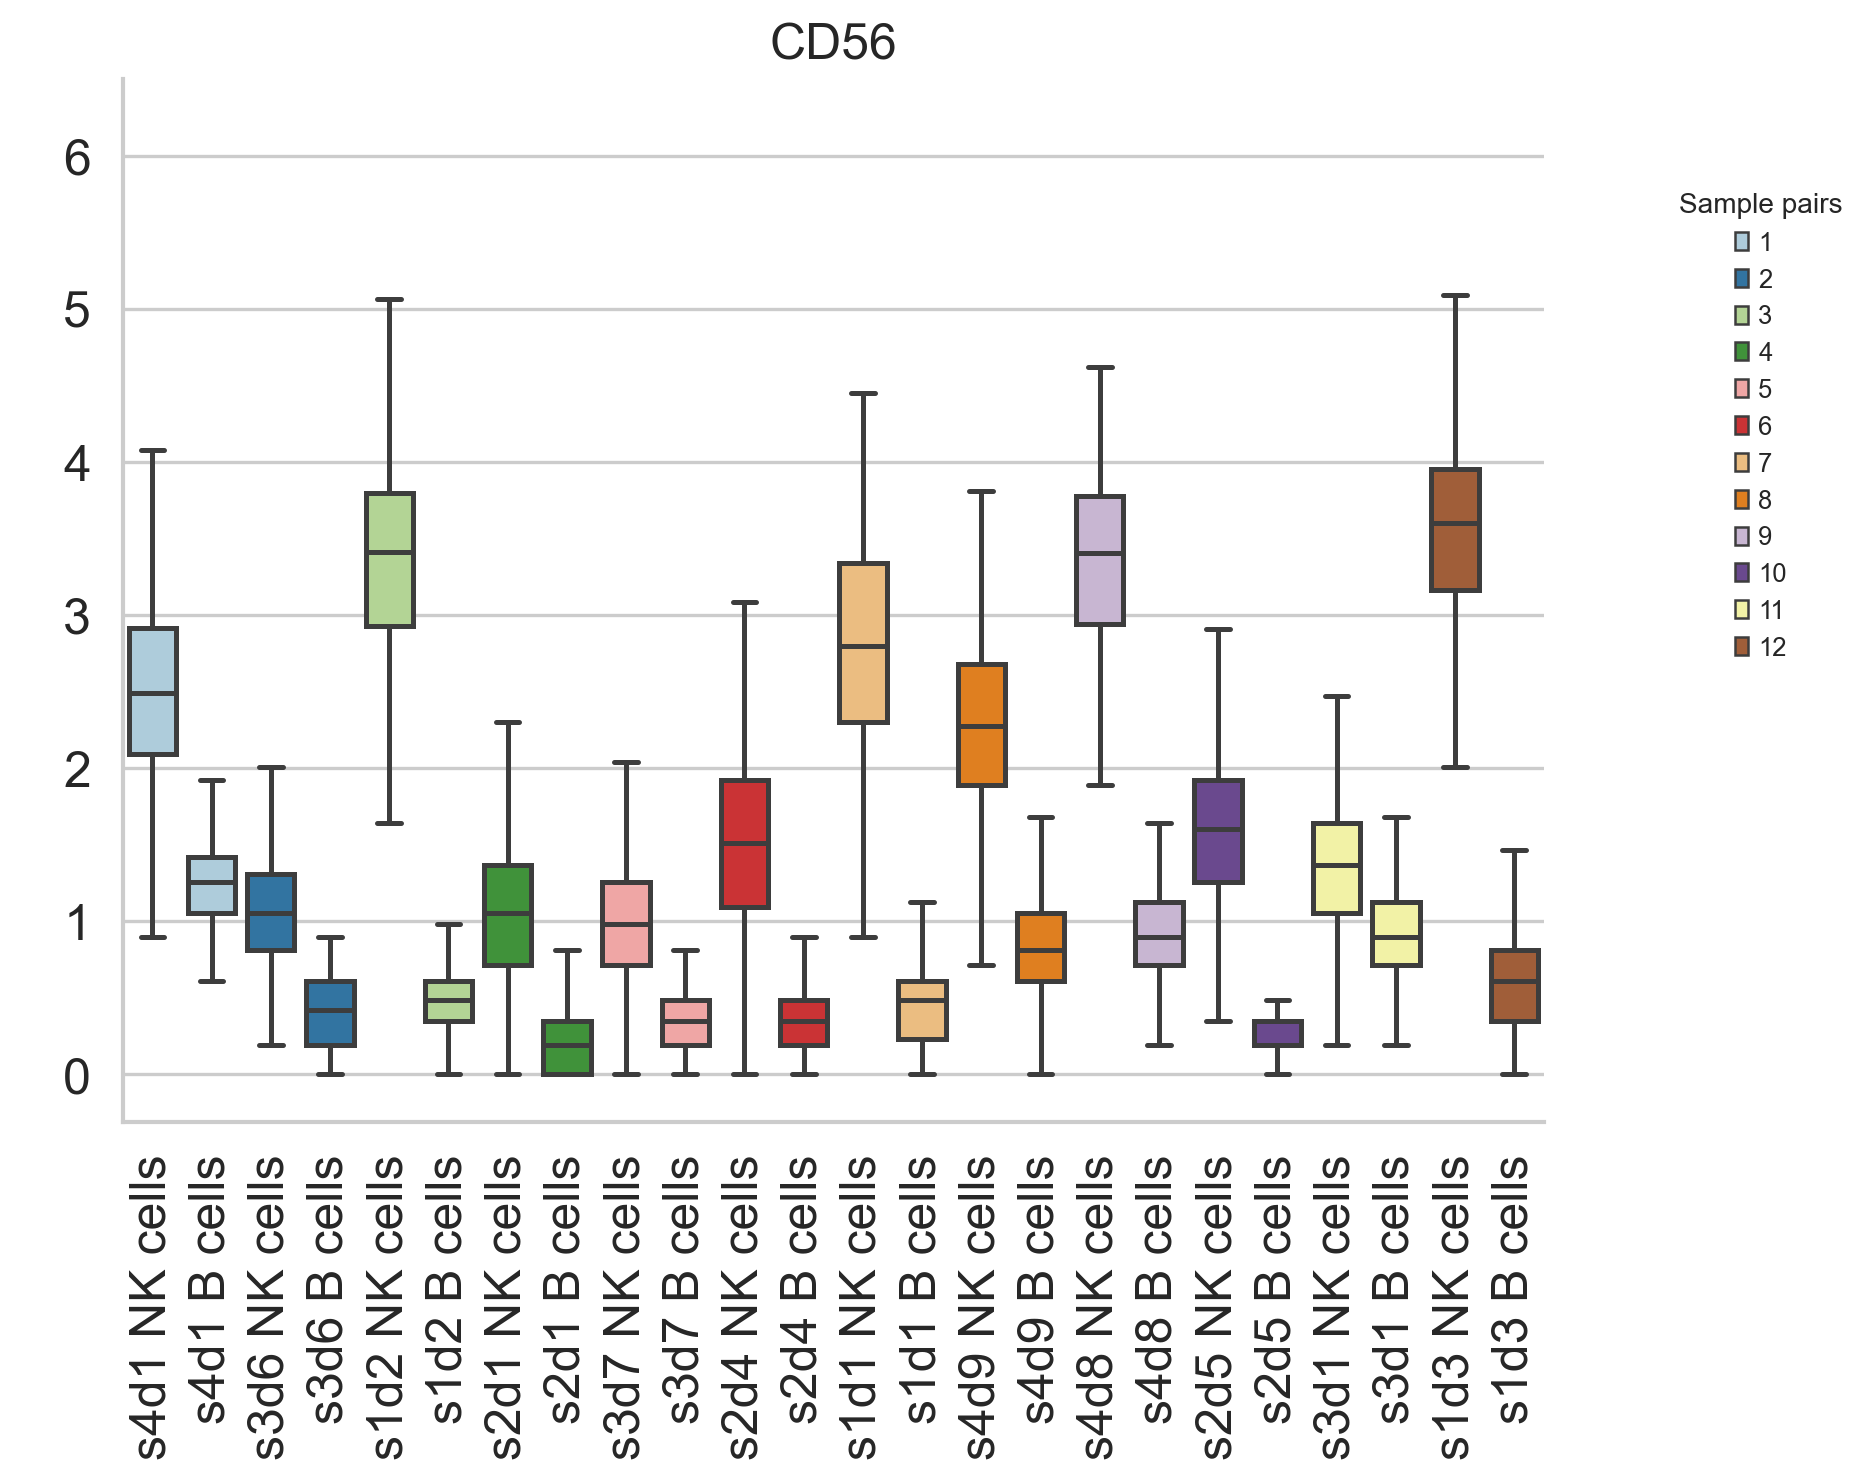

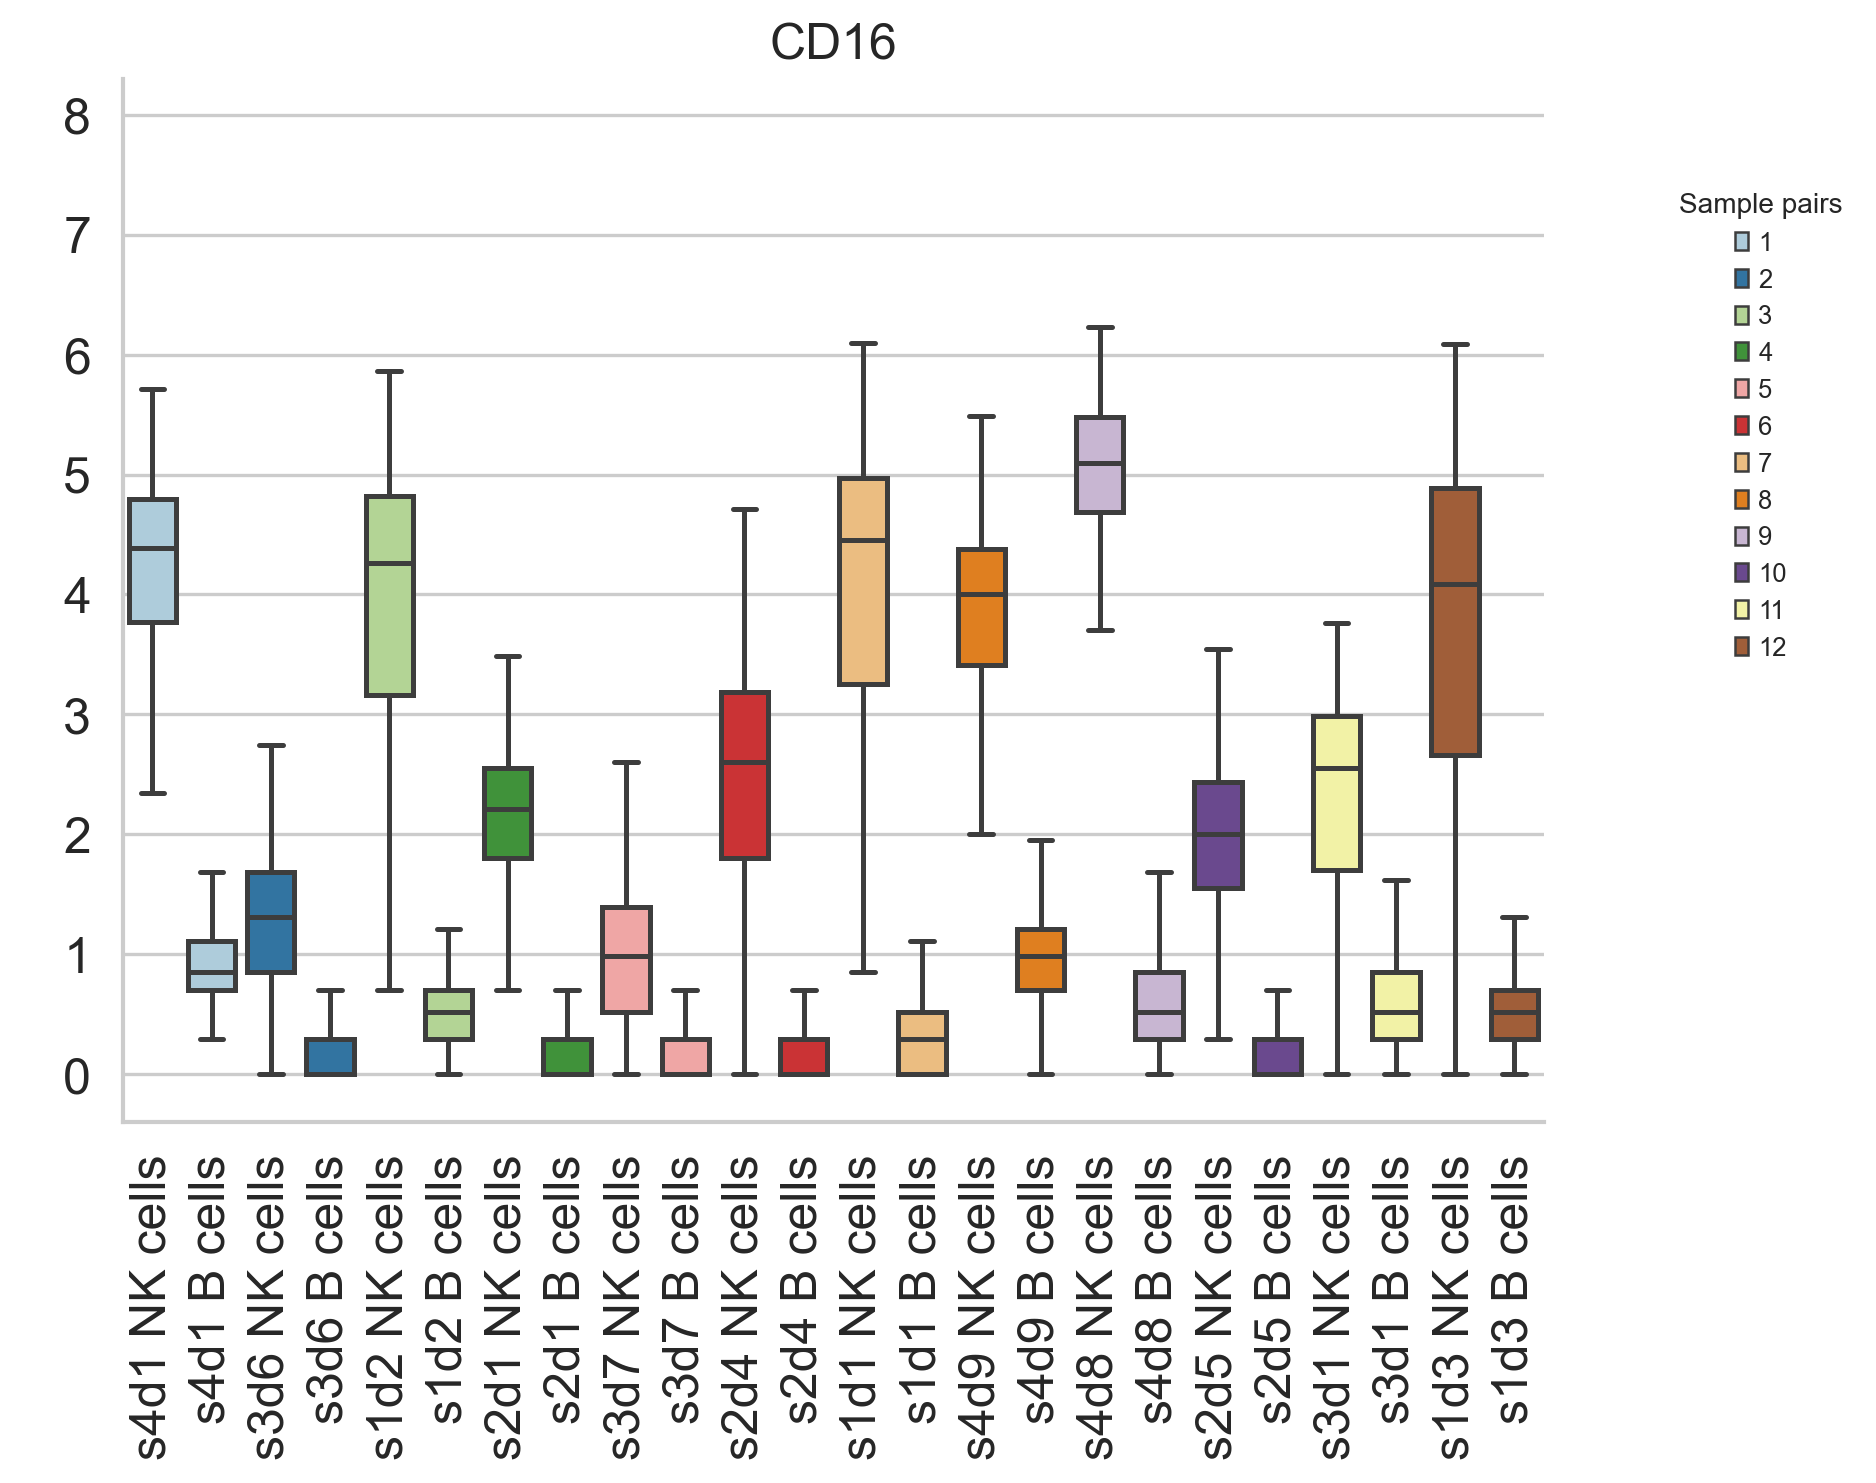

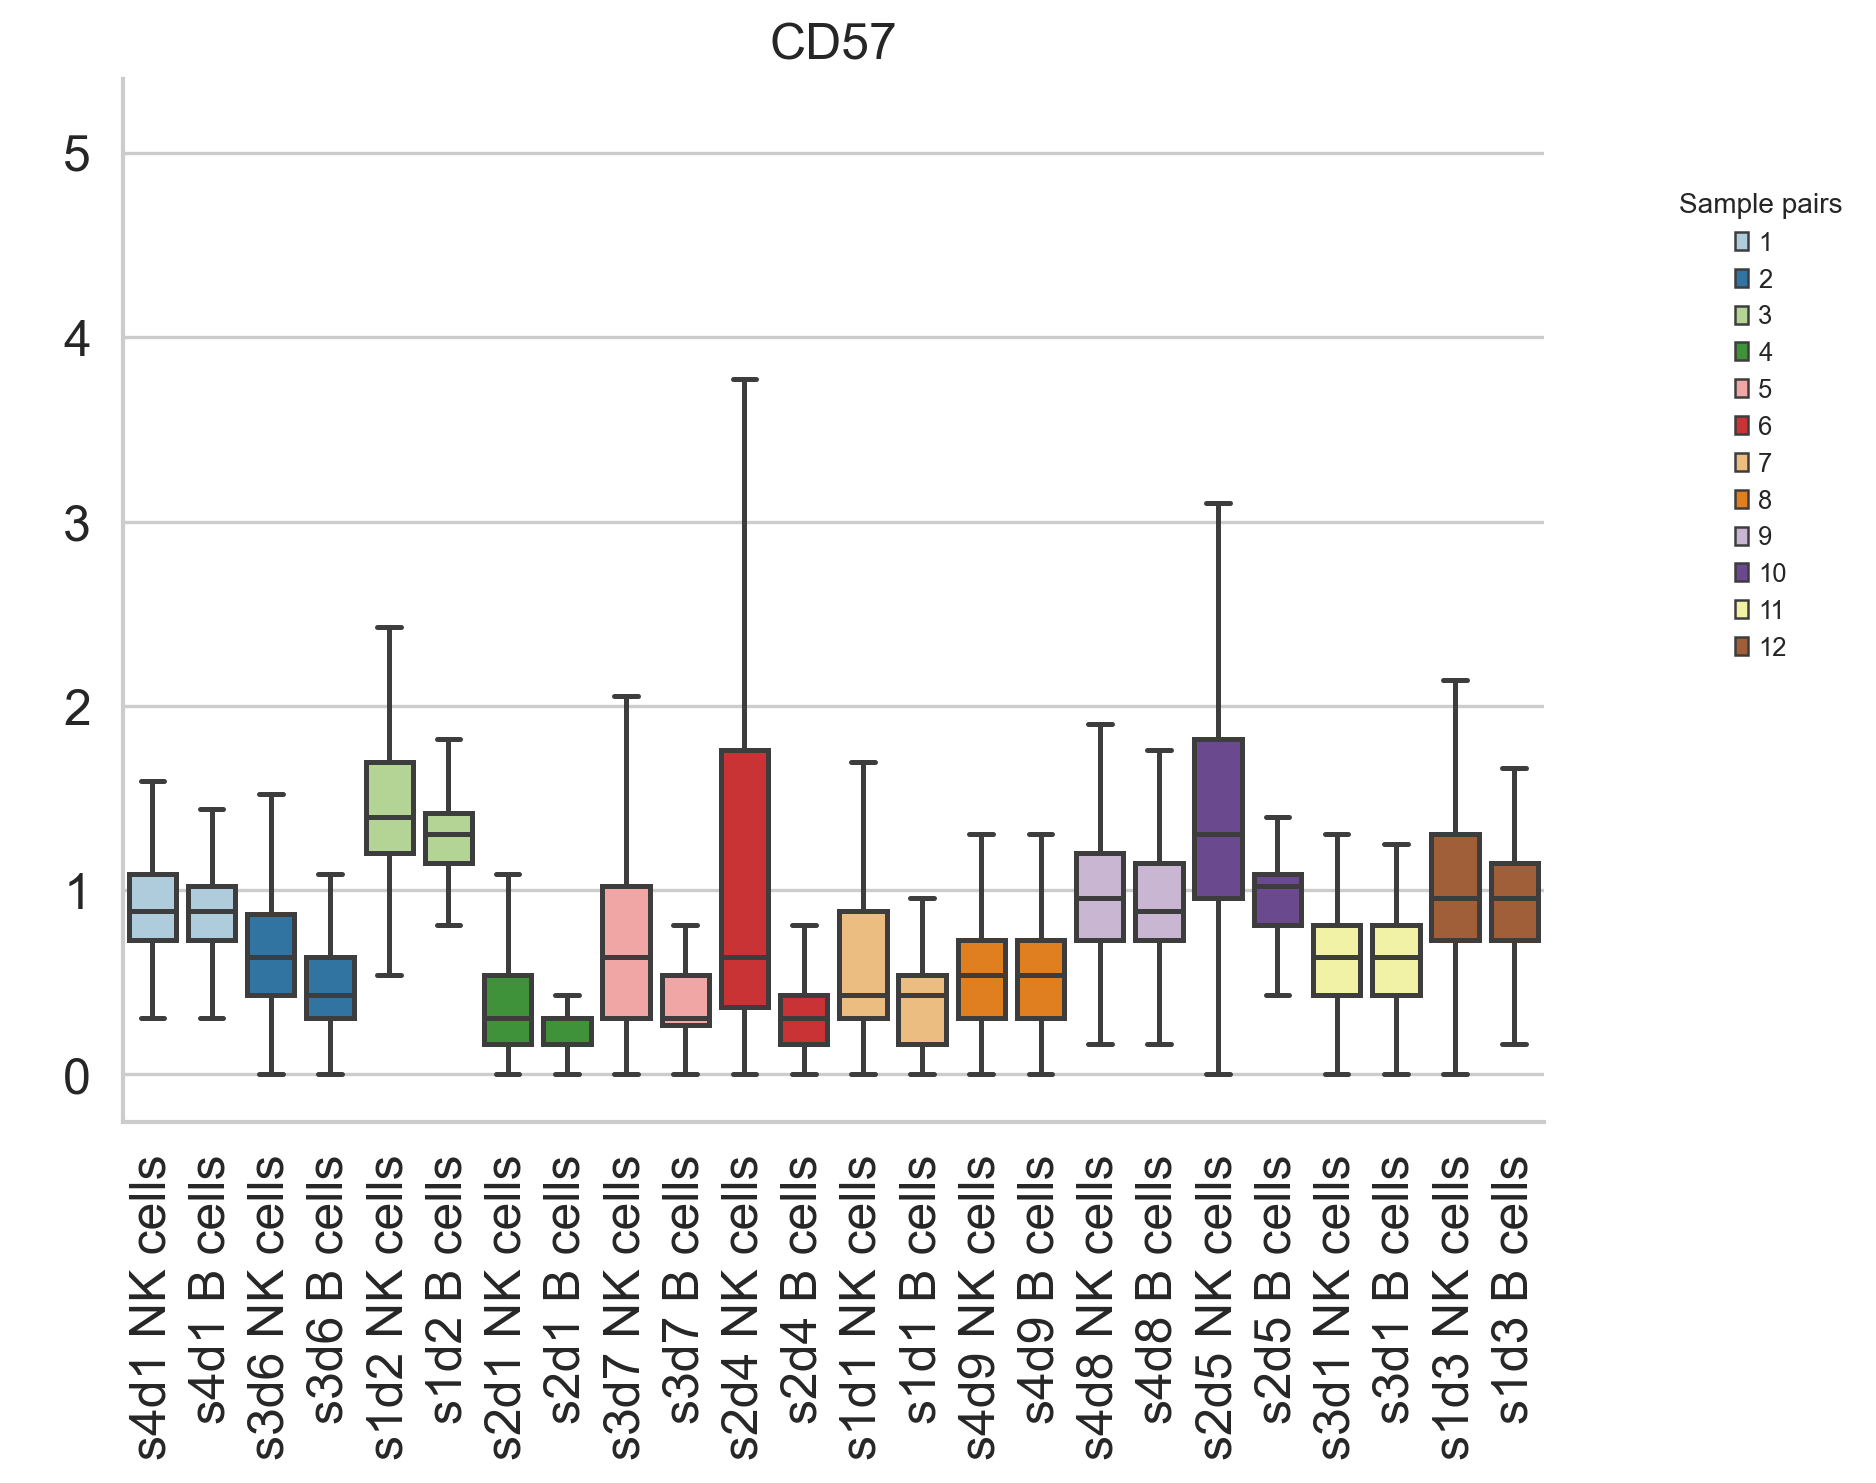

In [65]:
#sns.set(style='white', font_scale = 0.5, context='poster', rc={'figure.figsize':(7,7)})


#CD56
#CD57

sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD56", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf,
            legend = "CD16")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(12, 5)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set(xlabel=None)
ax.set_ylabels(' ')
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')
plt.title("CD56", fontsize=15)

plt.show()


#CD16


sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD16", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf,
            legend = "CD16")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(12, 5)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set(xlabel=None)
ax.set_ylabels(' ')
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')
plt.title("CD16", fontsize=15)

plt.show()


#CD57

sns.set_theme(style = "whitegrid", font_scale= 0.7)
ax = sns.catplot(x="Sample", y="CD57", hue="Samplepair",
            aspect=.4,fliersize=0,dodge=False, 
            kind="box",palette = 'Paired', data=cdf,
            legend = "CD16")
ax.set_xticklabels(rotation = 90)
ax.fig.set_size_inches(12, 5)
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=15)
ax.set(xlabel=None)
ax.set_ylabels(' ')
sns.move_legend(ax, "upper right", bbox_to_anchor=(.85, .9), title='Sample pairs')
plt.title("CD57", fontsize=15)

plt.show()



In [66]:
samples=adata_neurips.obs['POOL'].unique().tolist()

In [67]:
#saving isotype control df, only NK cells. 

ig_ab = neurips_nk.obsm['ADT_isotype_controls']

In [68]:
#collecting column names

isotype_col = ig_ab.columns

In [69]:
isotype_col

Index(['Mouse-IgG1', 'Mouse-IgG2a', 'Mouse-IgG2b', 'Rat-IgG2b', 'Rat-IgG1',
       'Rat-IgG2a'],
      dtype='object')

In [70]:
#saving isotype marker counts from all samples into a list

list_isotype=[]

for sample in samples:
    eg=adata_neurips[(adata_neurips.obs['cell_type'] ==  "NK") | (adata_neurips.obs['cell_type'] == "NK CD158e1+")]
    eg1=eg[eg.obs['POOL'] == sample]
    prot=eg1.obsm['ADT_isotype_controls']
    prot_marker=prot[isotype_col]
    list_isotype.append(prot_marker)

In [71]:
#Adding sample names

thelist=[]

for i in range(len(list_isotype)):
    sample= list_isotype[i]
    sample["Sample"]=samples[i]
    thelist.append(sample)

#Creating df

df_isotype=pd.concat(thelist, axis=0)

In [72]:
#dropping "sample" column
df_nk = df_nk.drop(df_nk.columns[-1], axis=1)

In [73]:
#Combine df of NK cell marker counts + isotype controls

df=pd.concat([df_nk, df_isotype], axis = 1)
df.shape

(7388, 31)

<Figure size 1200x600 with 0 Axes>

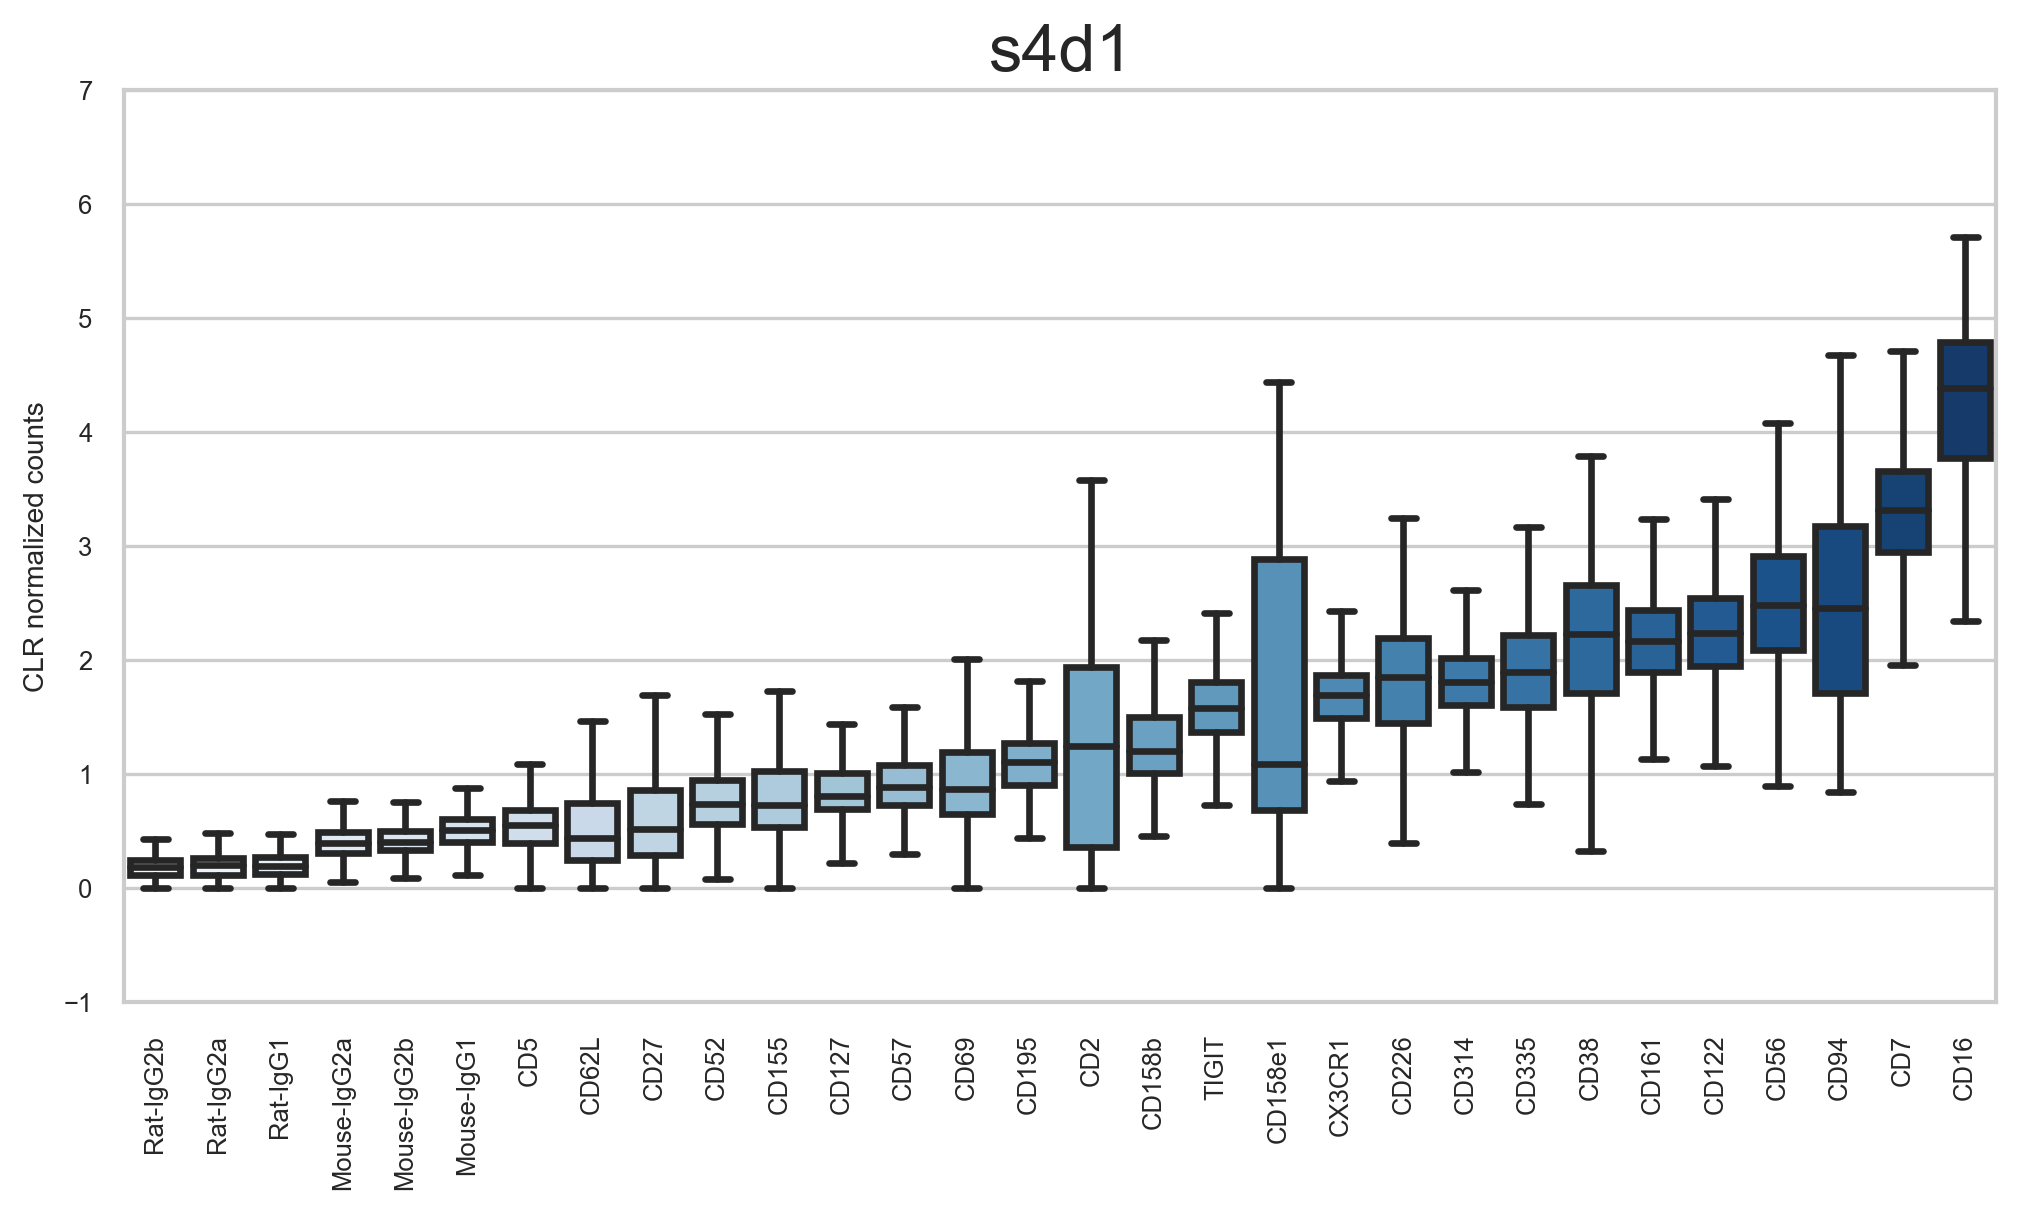

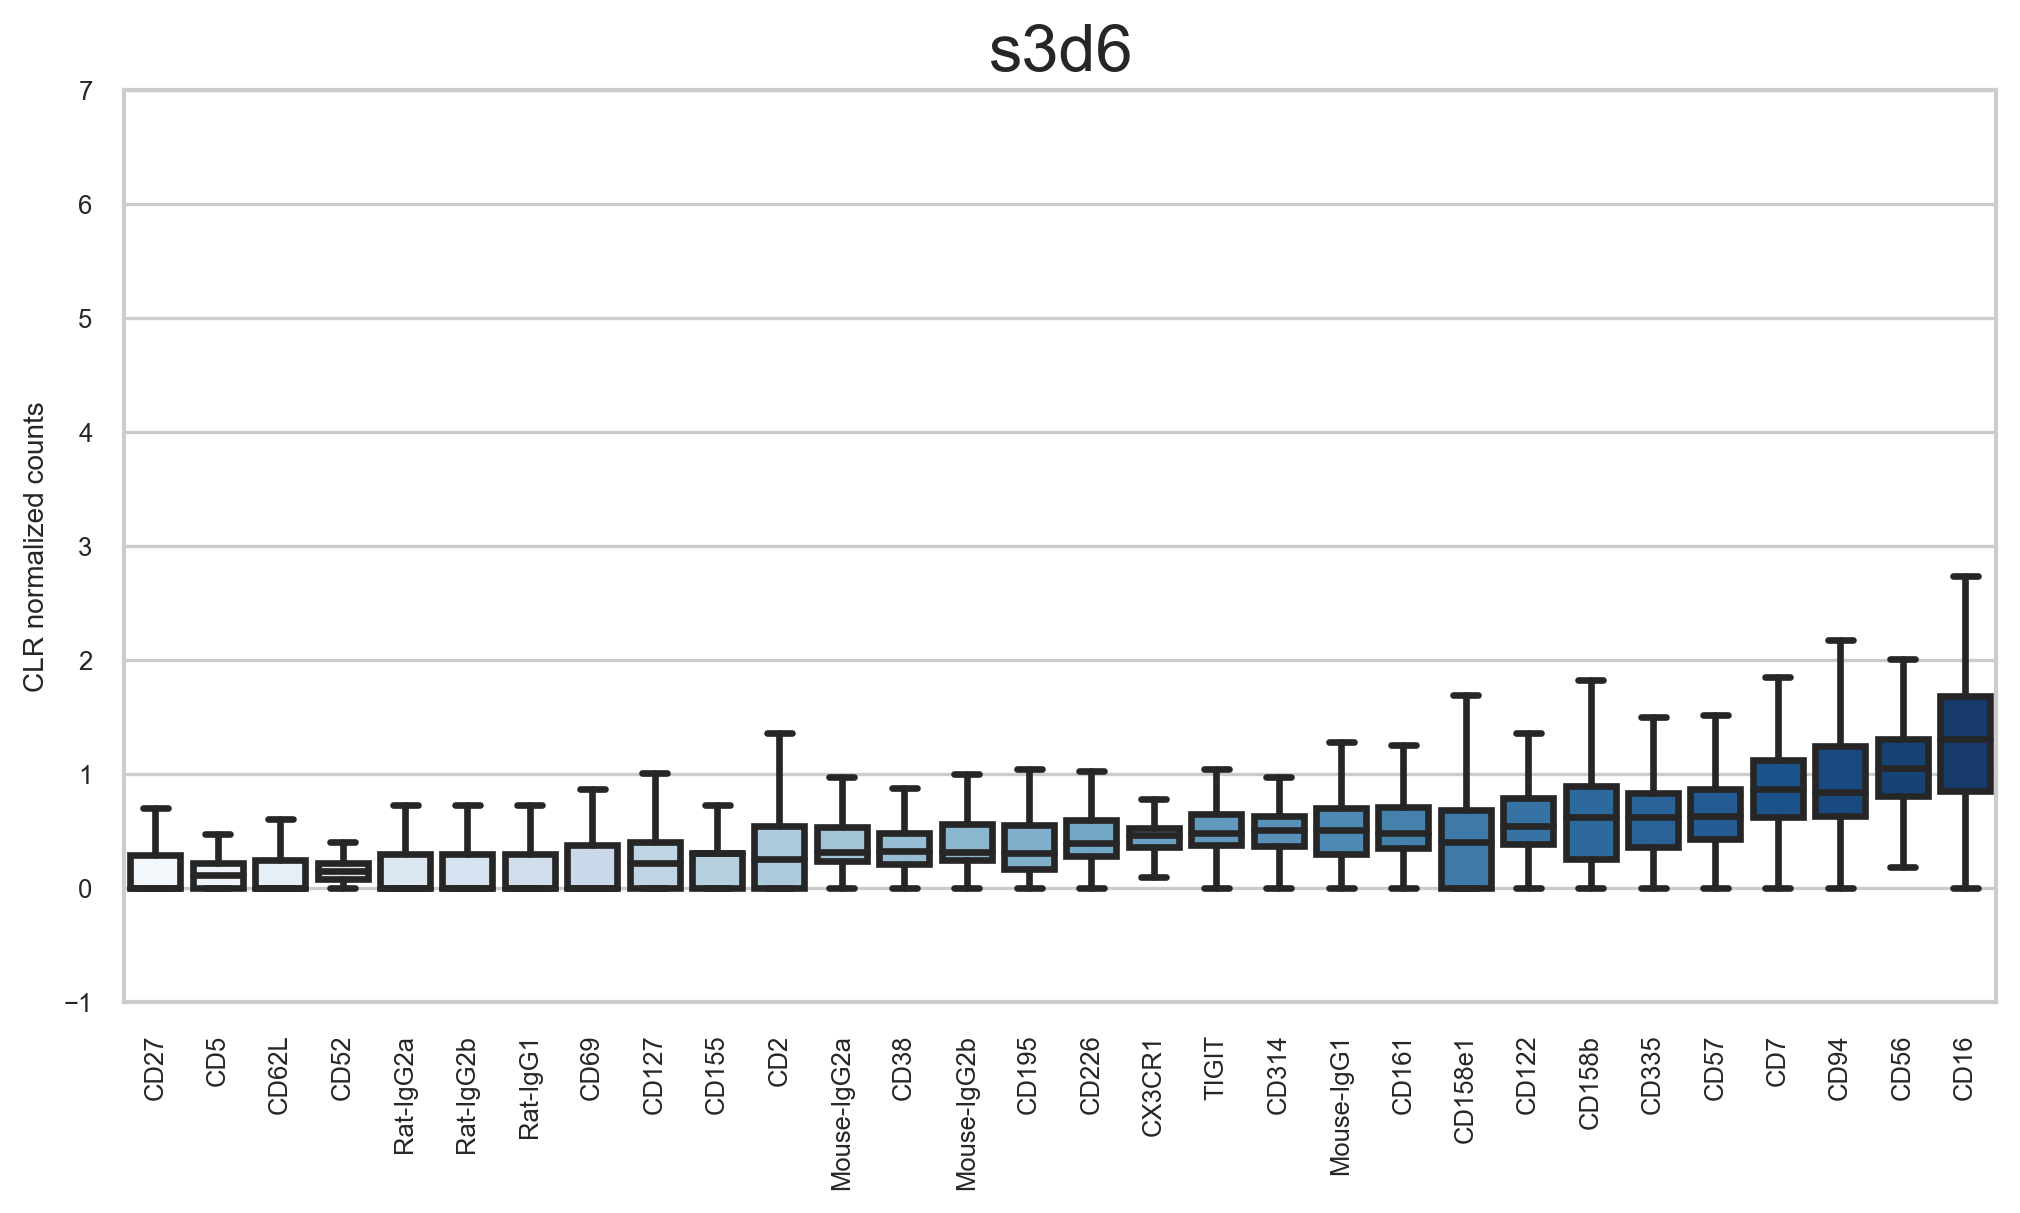

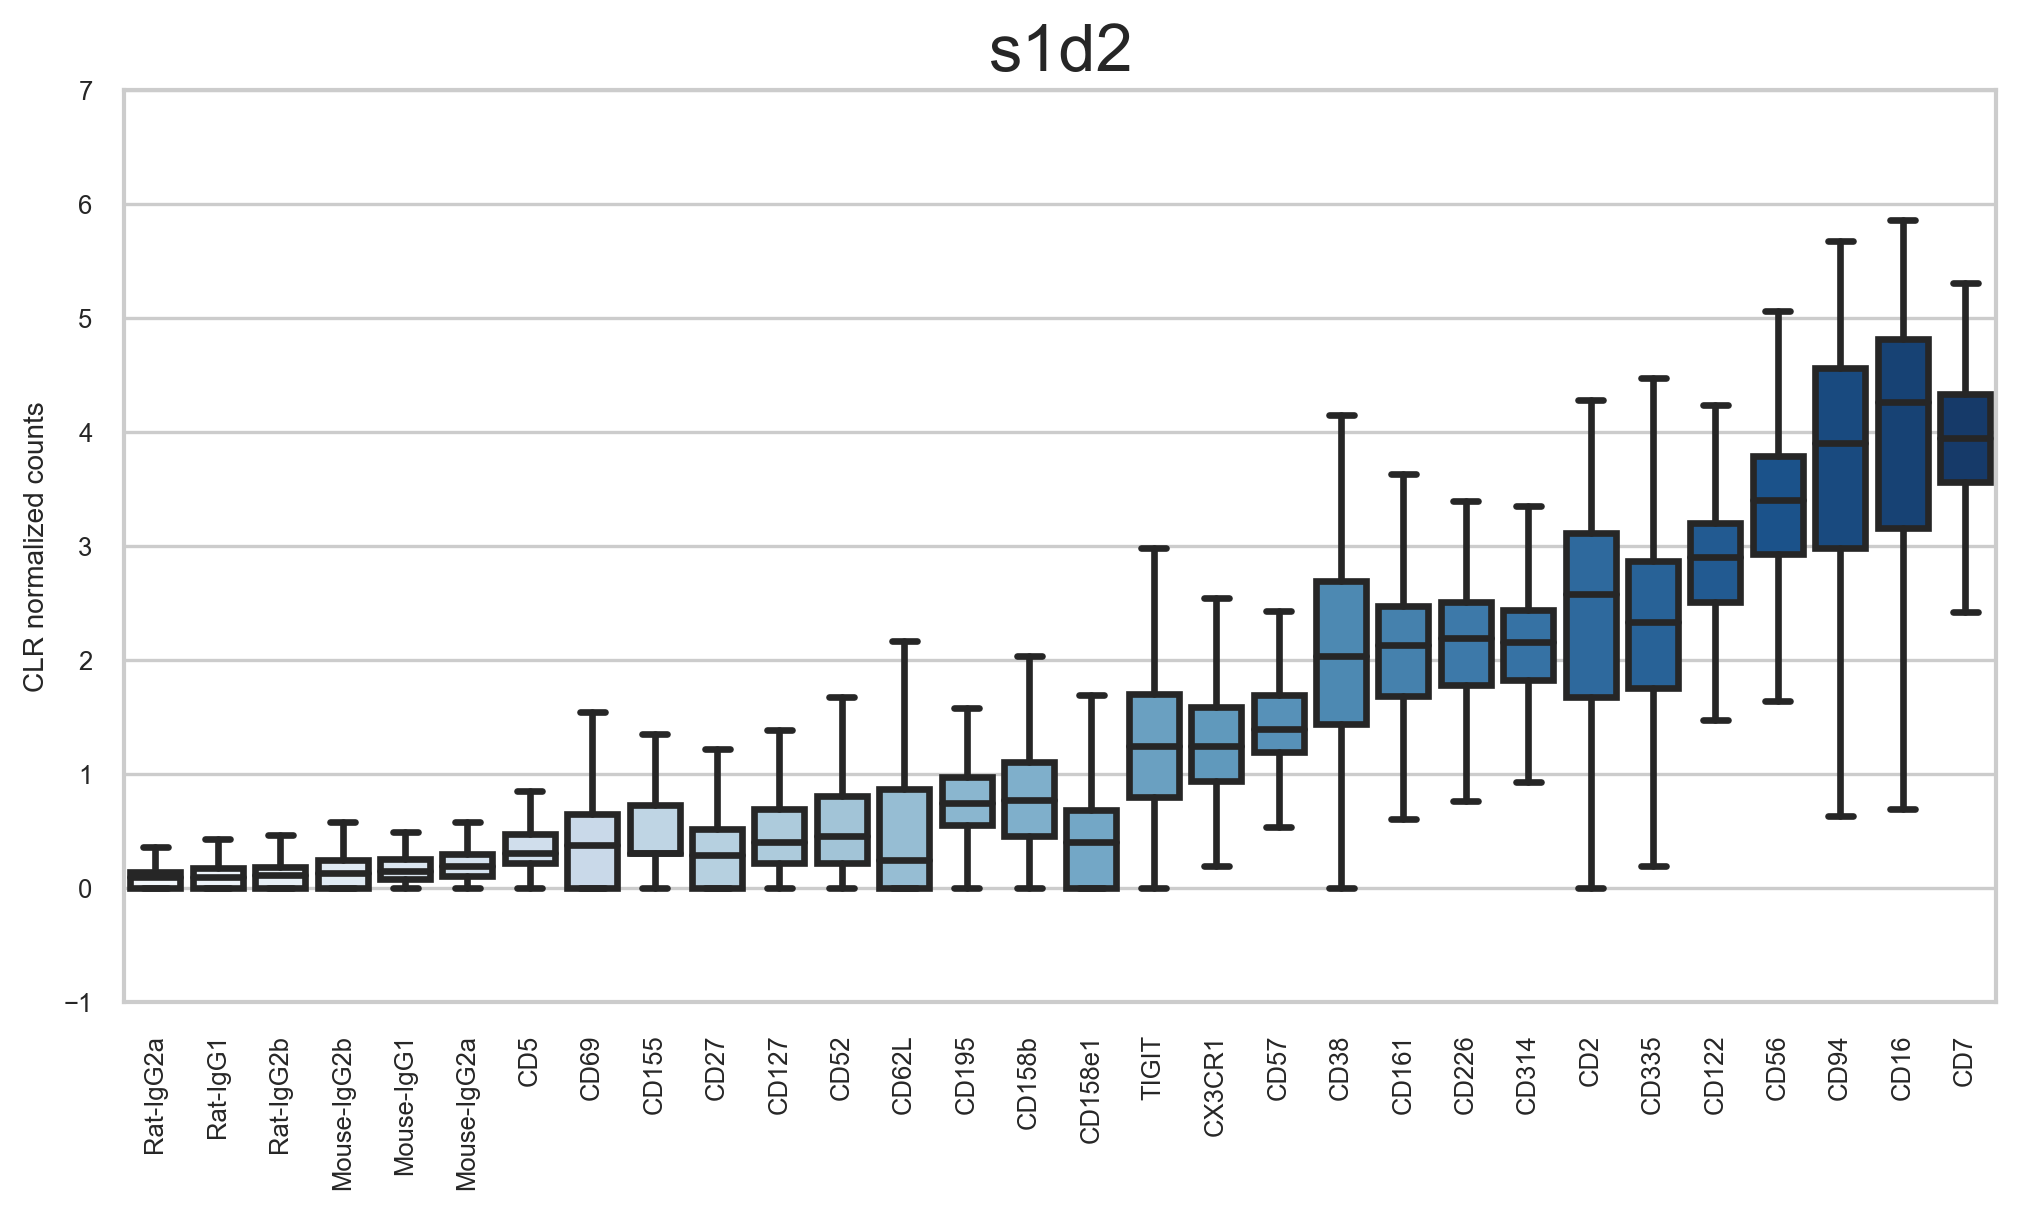

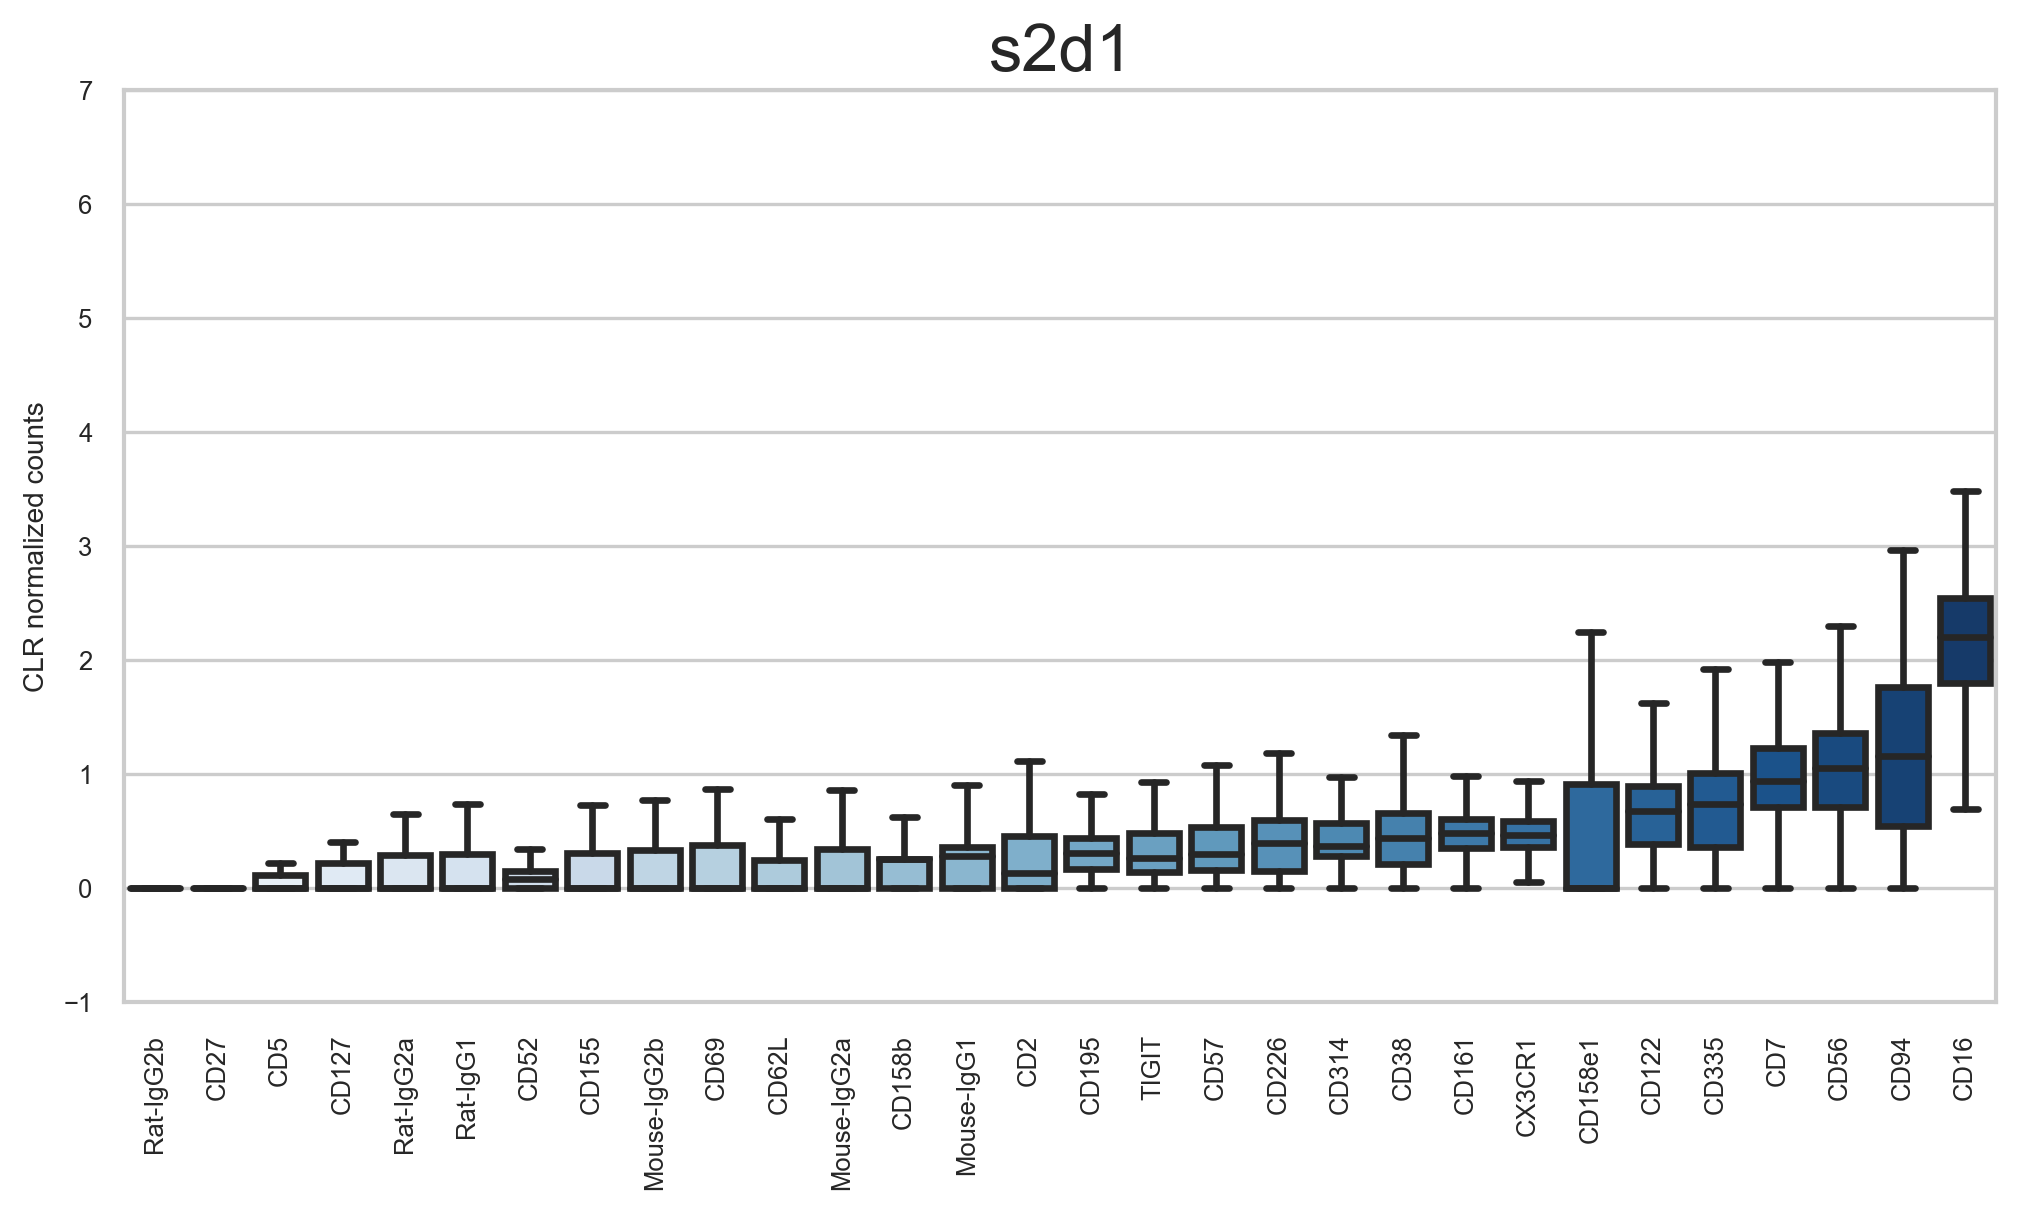

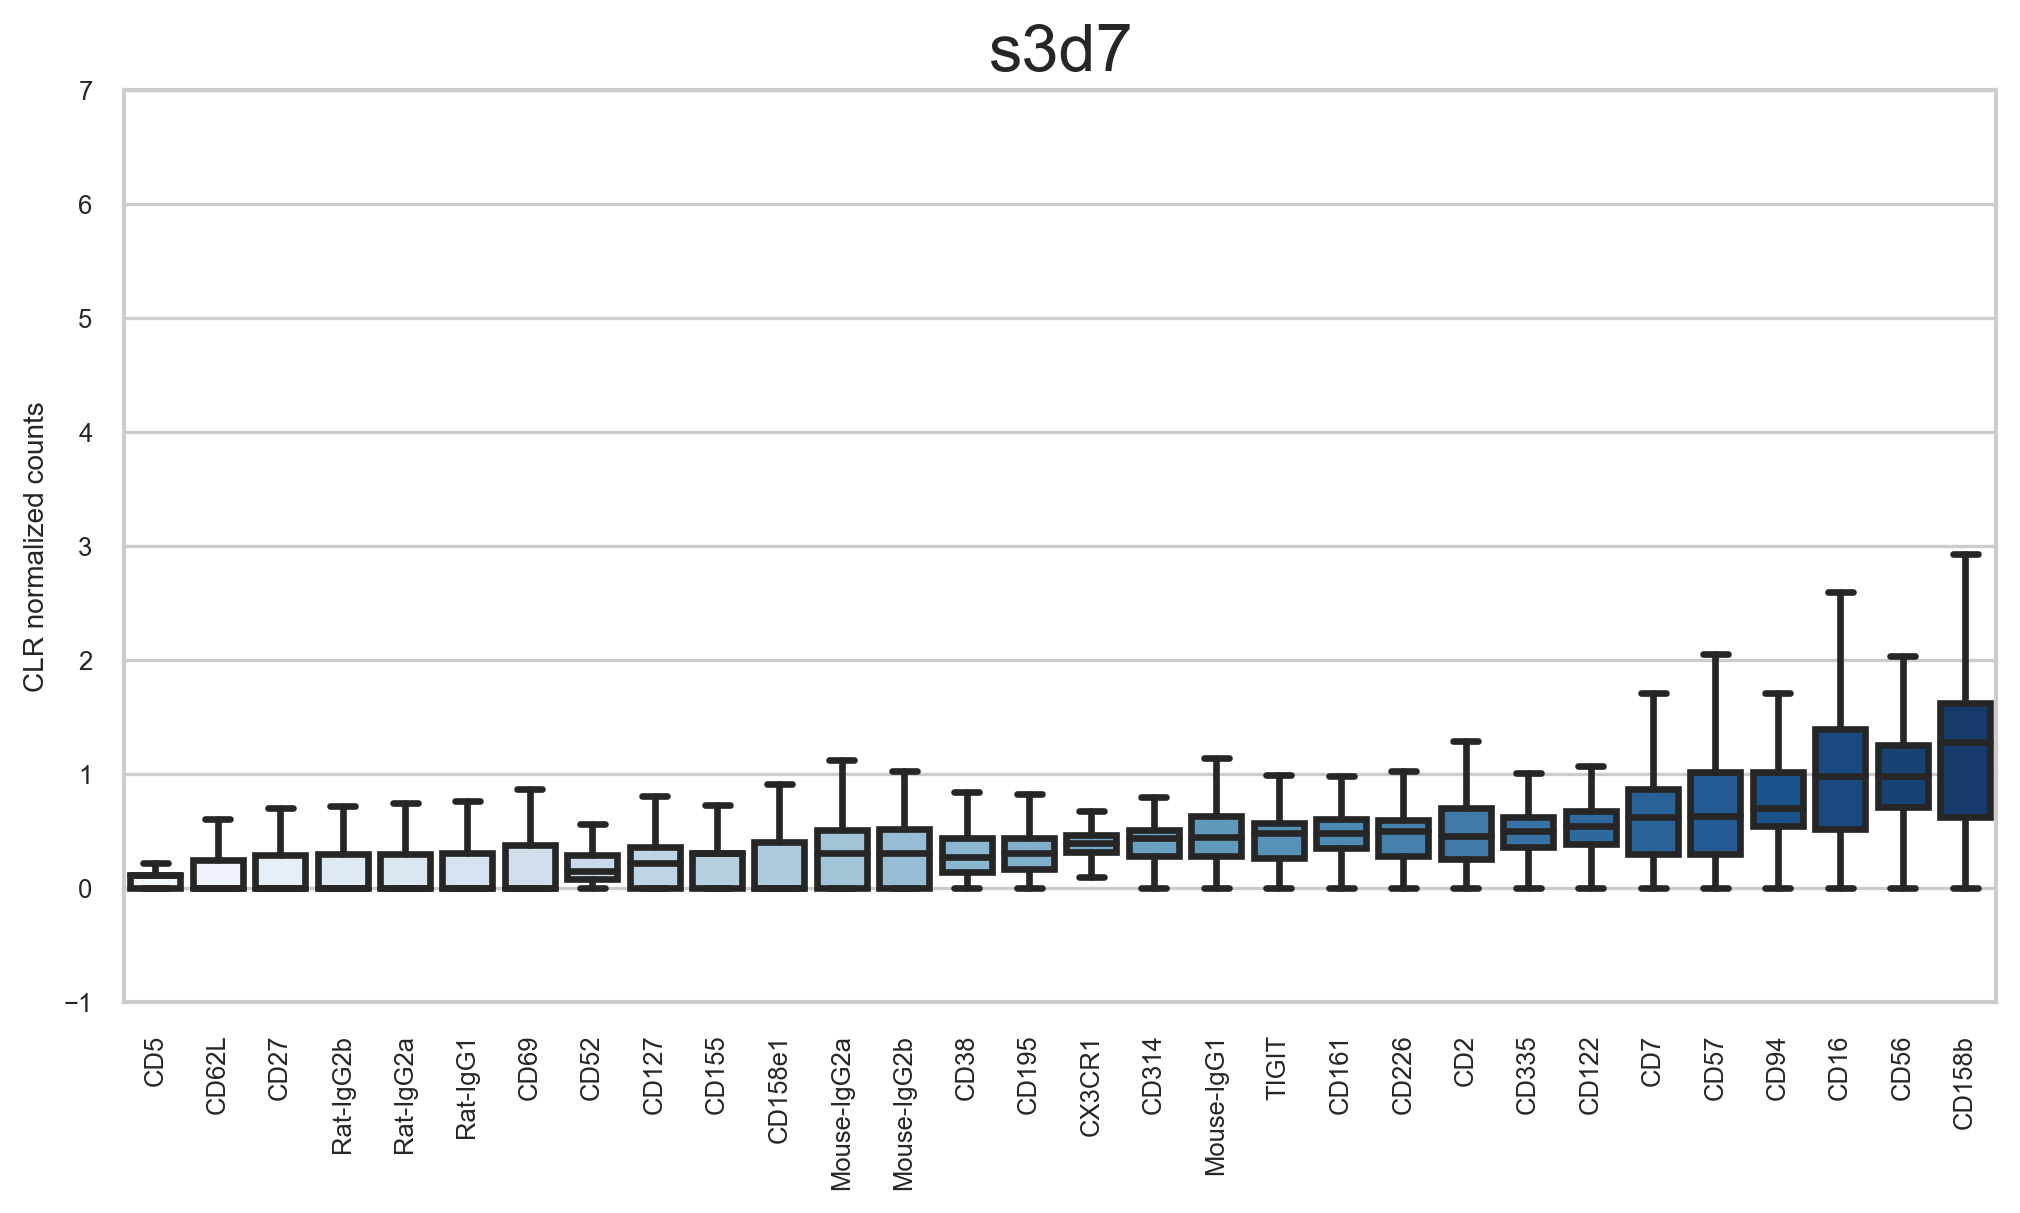

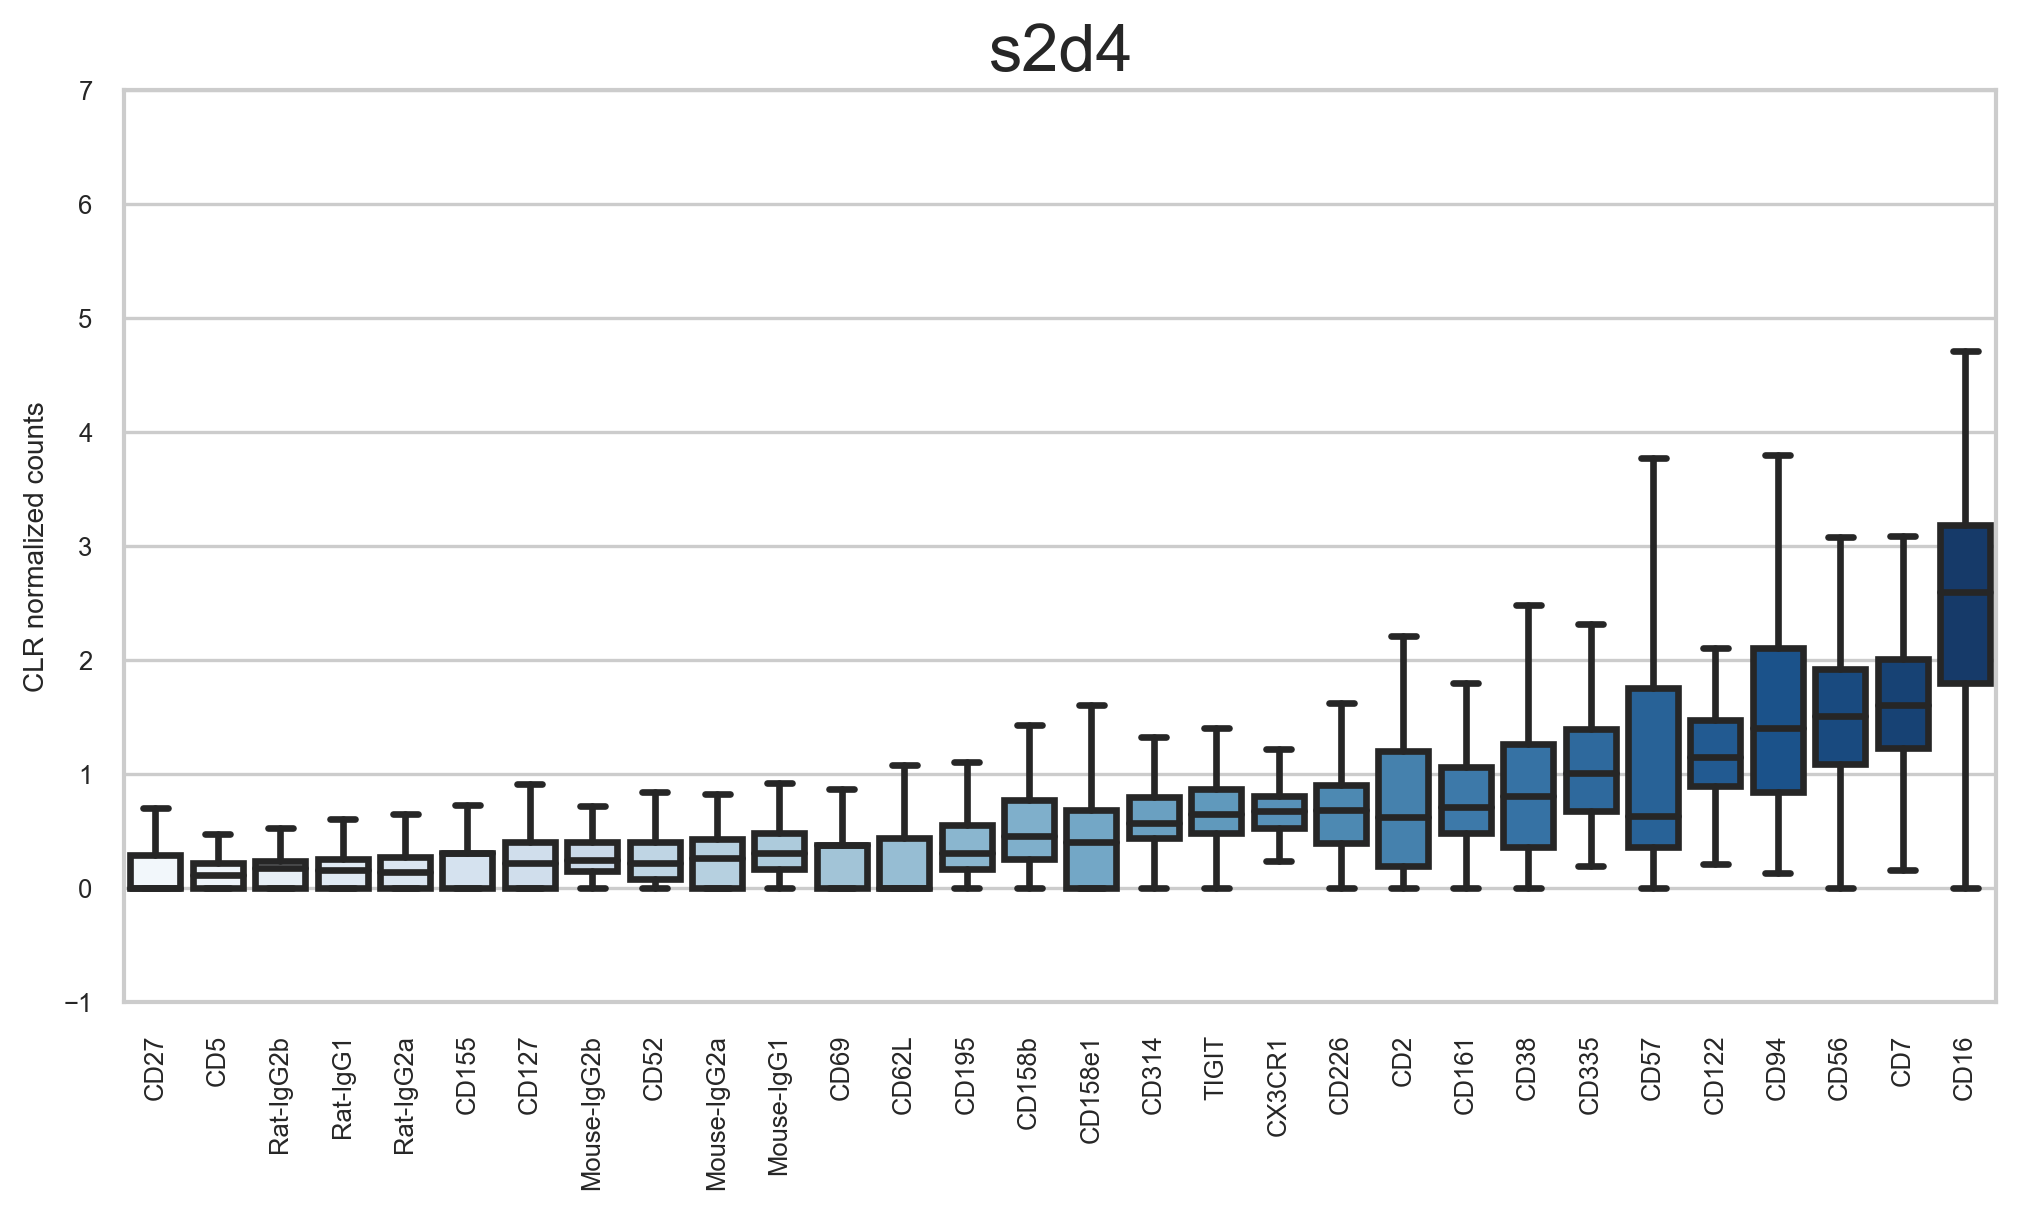

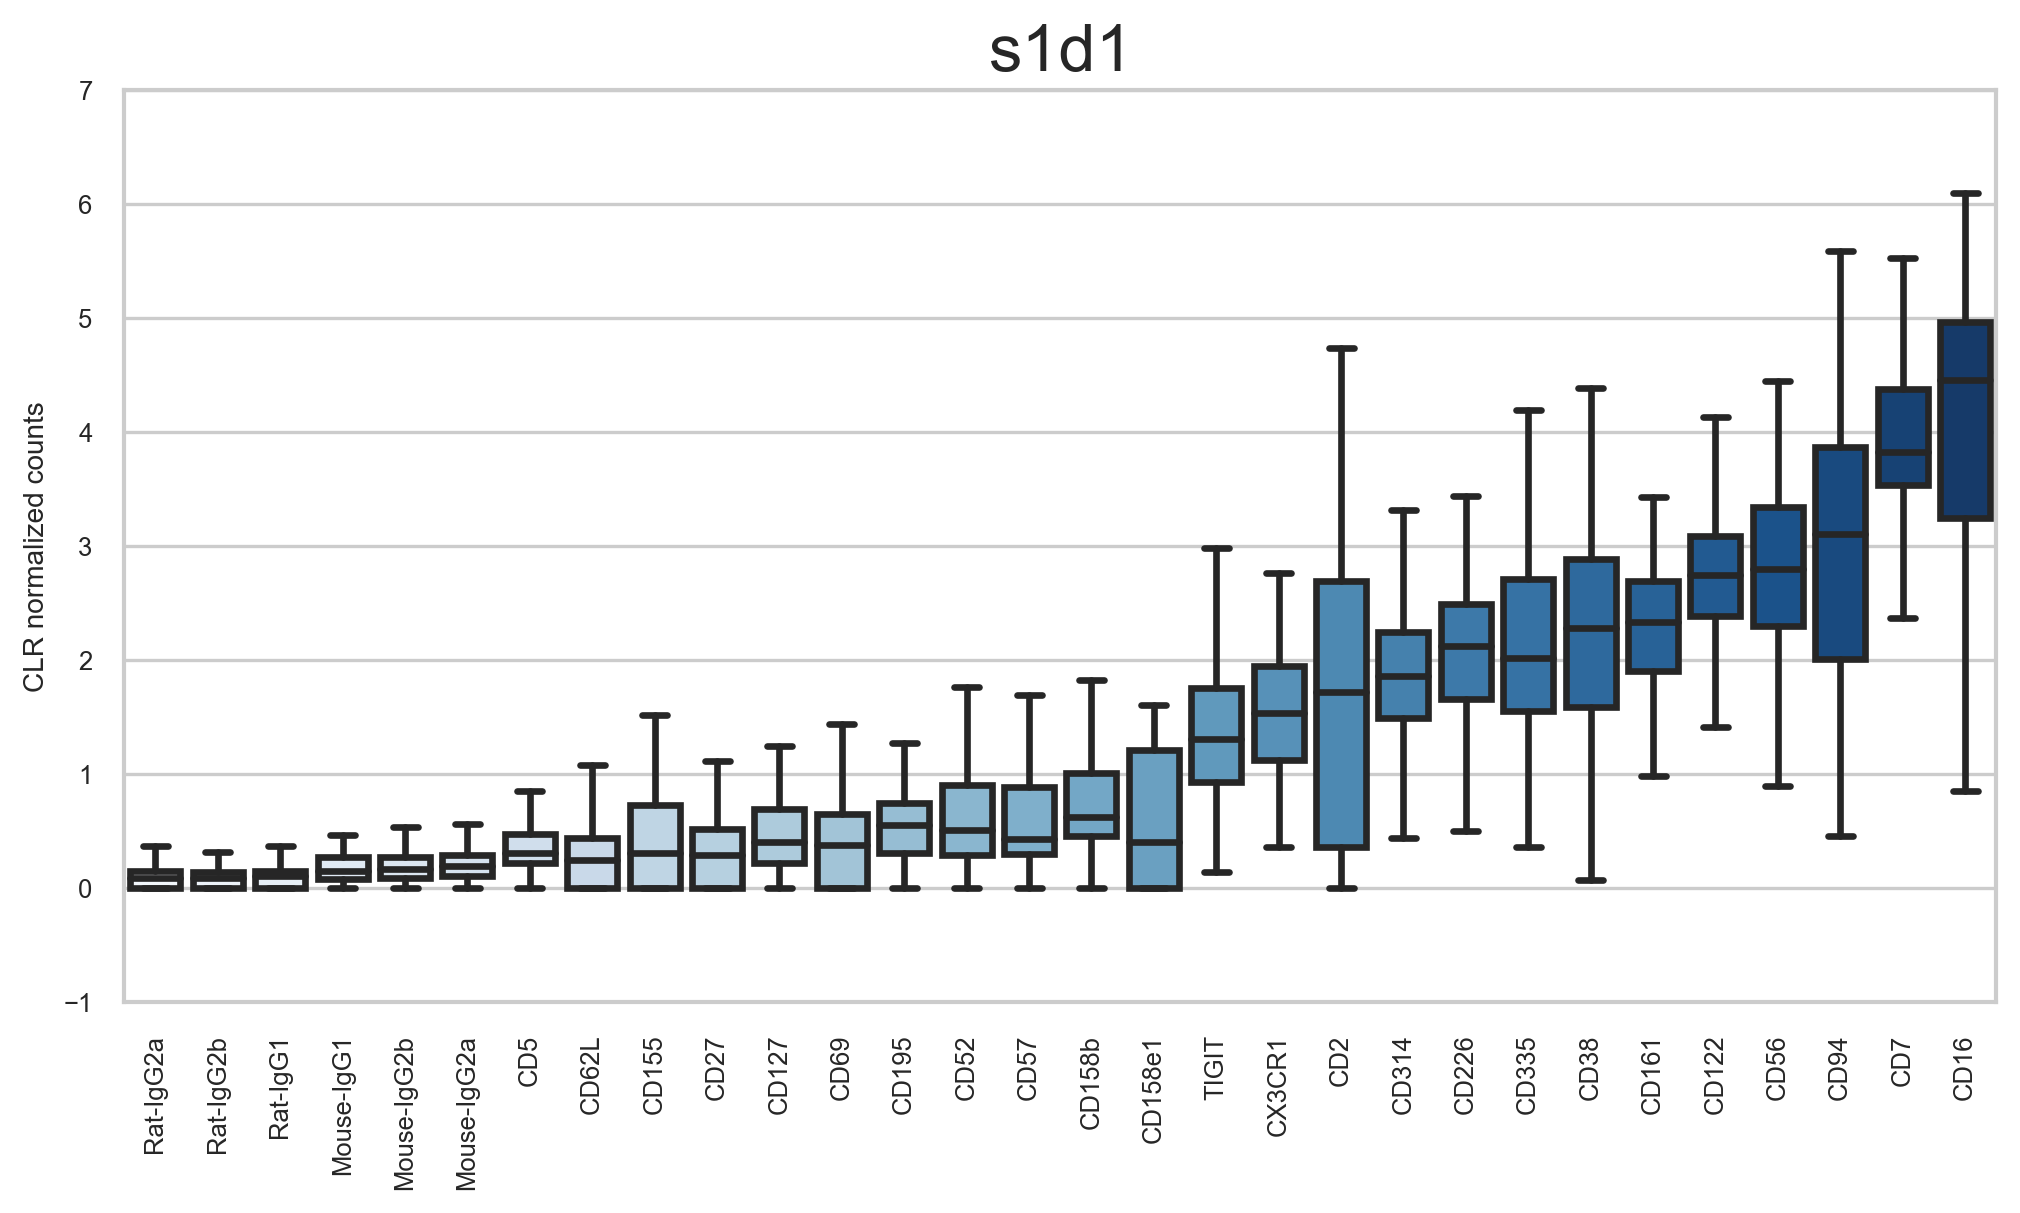

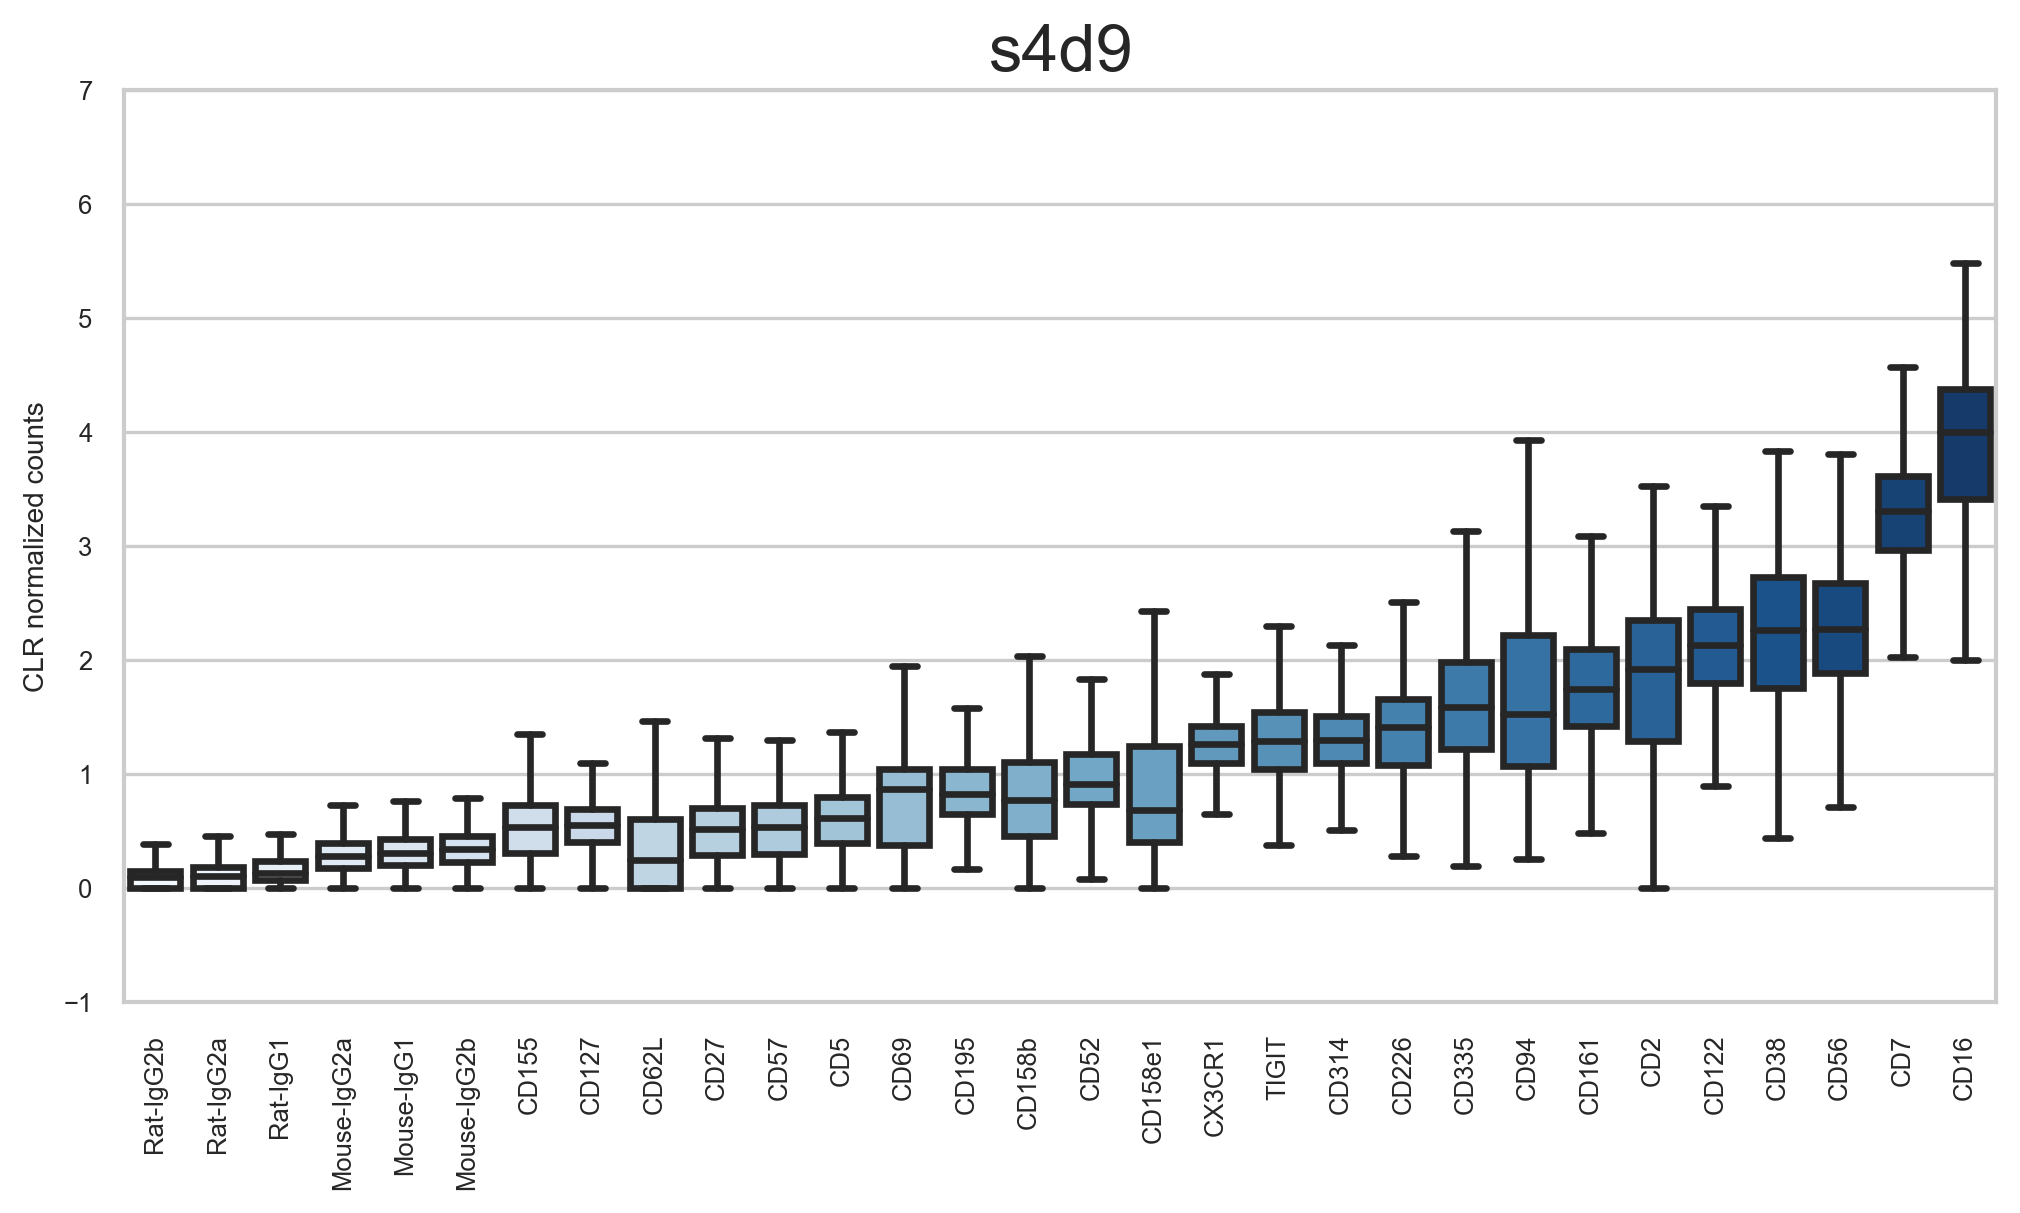

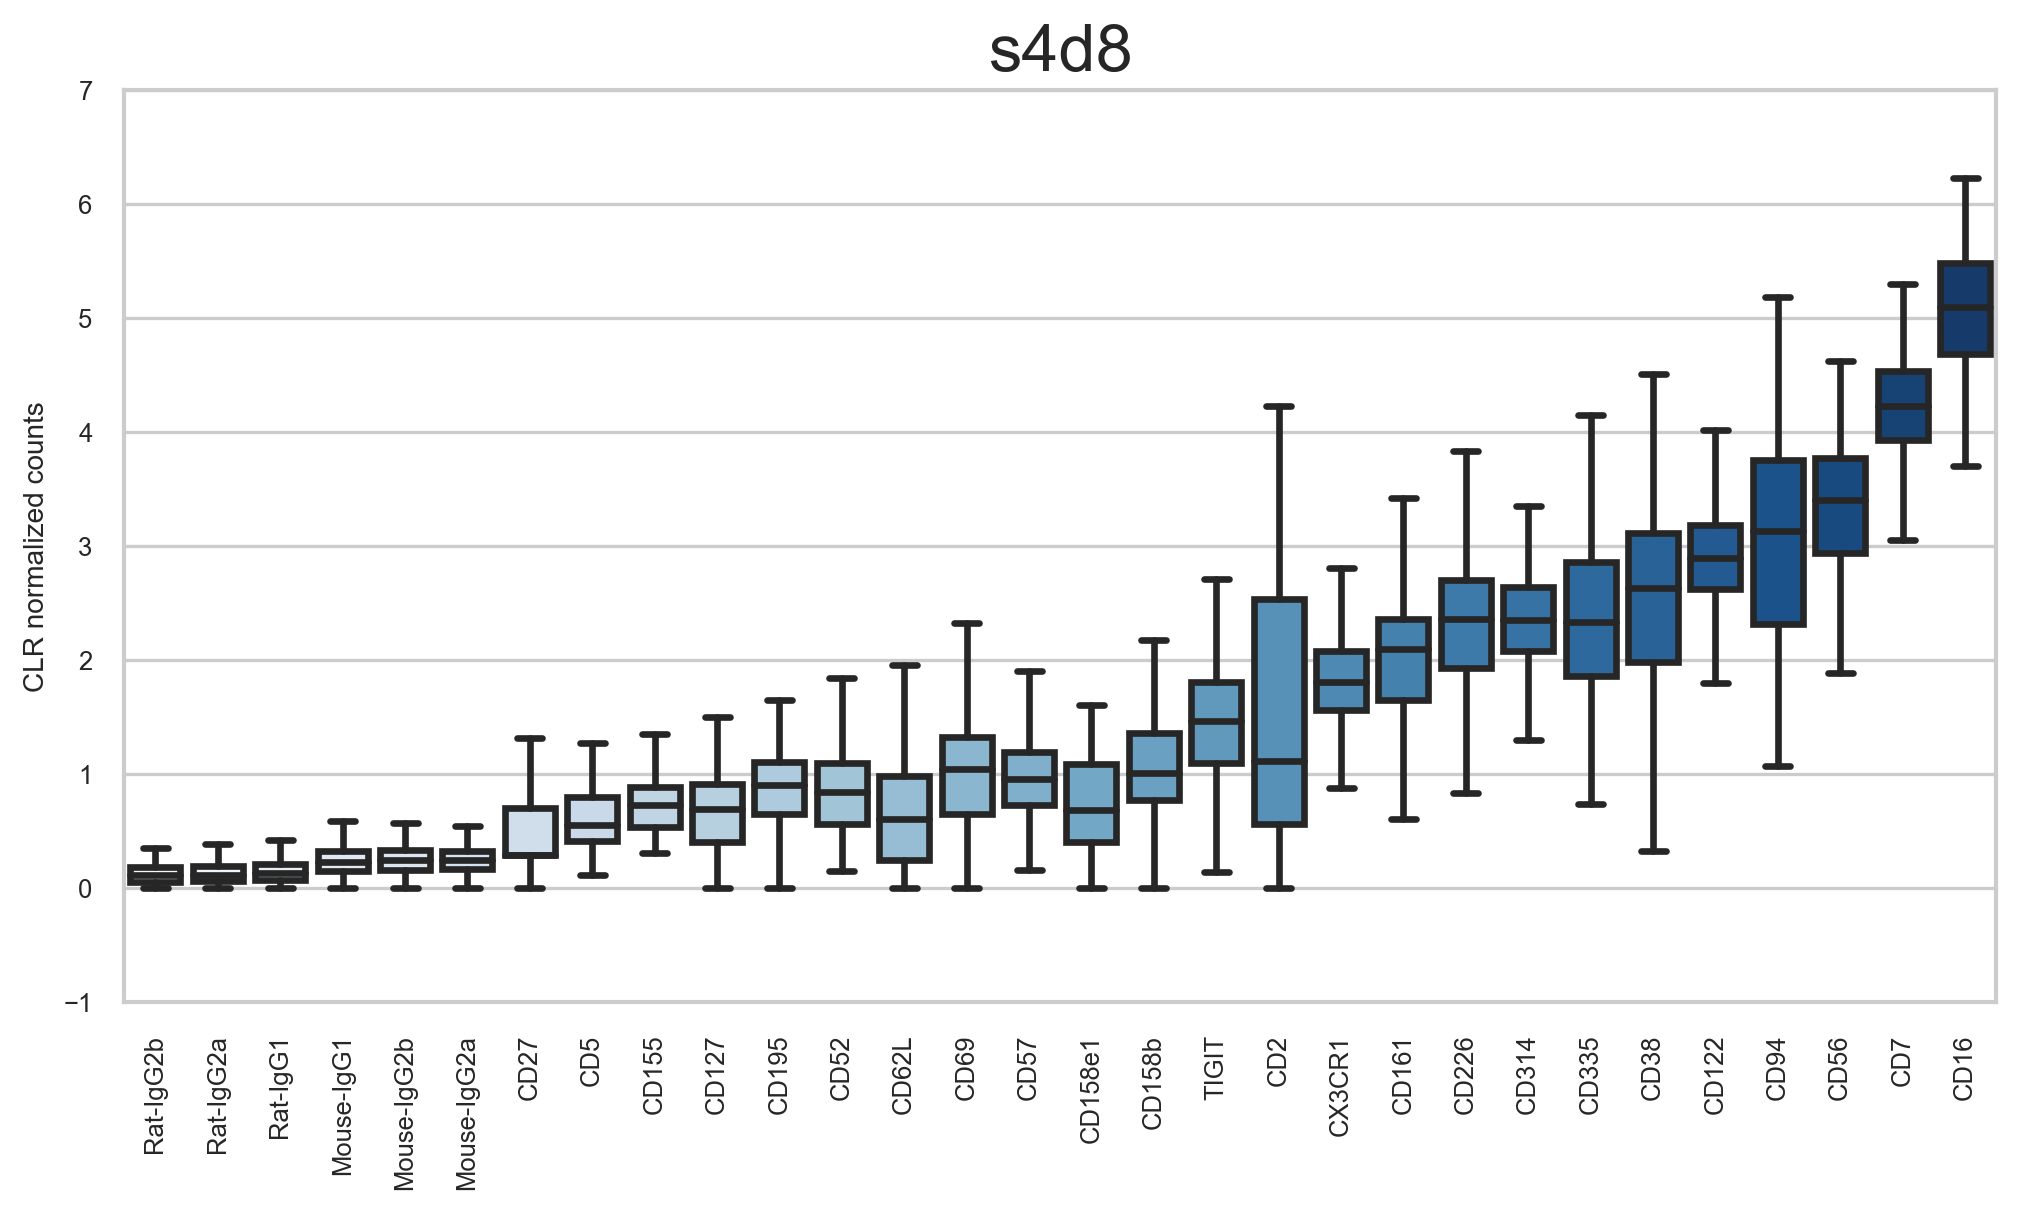

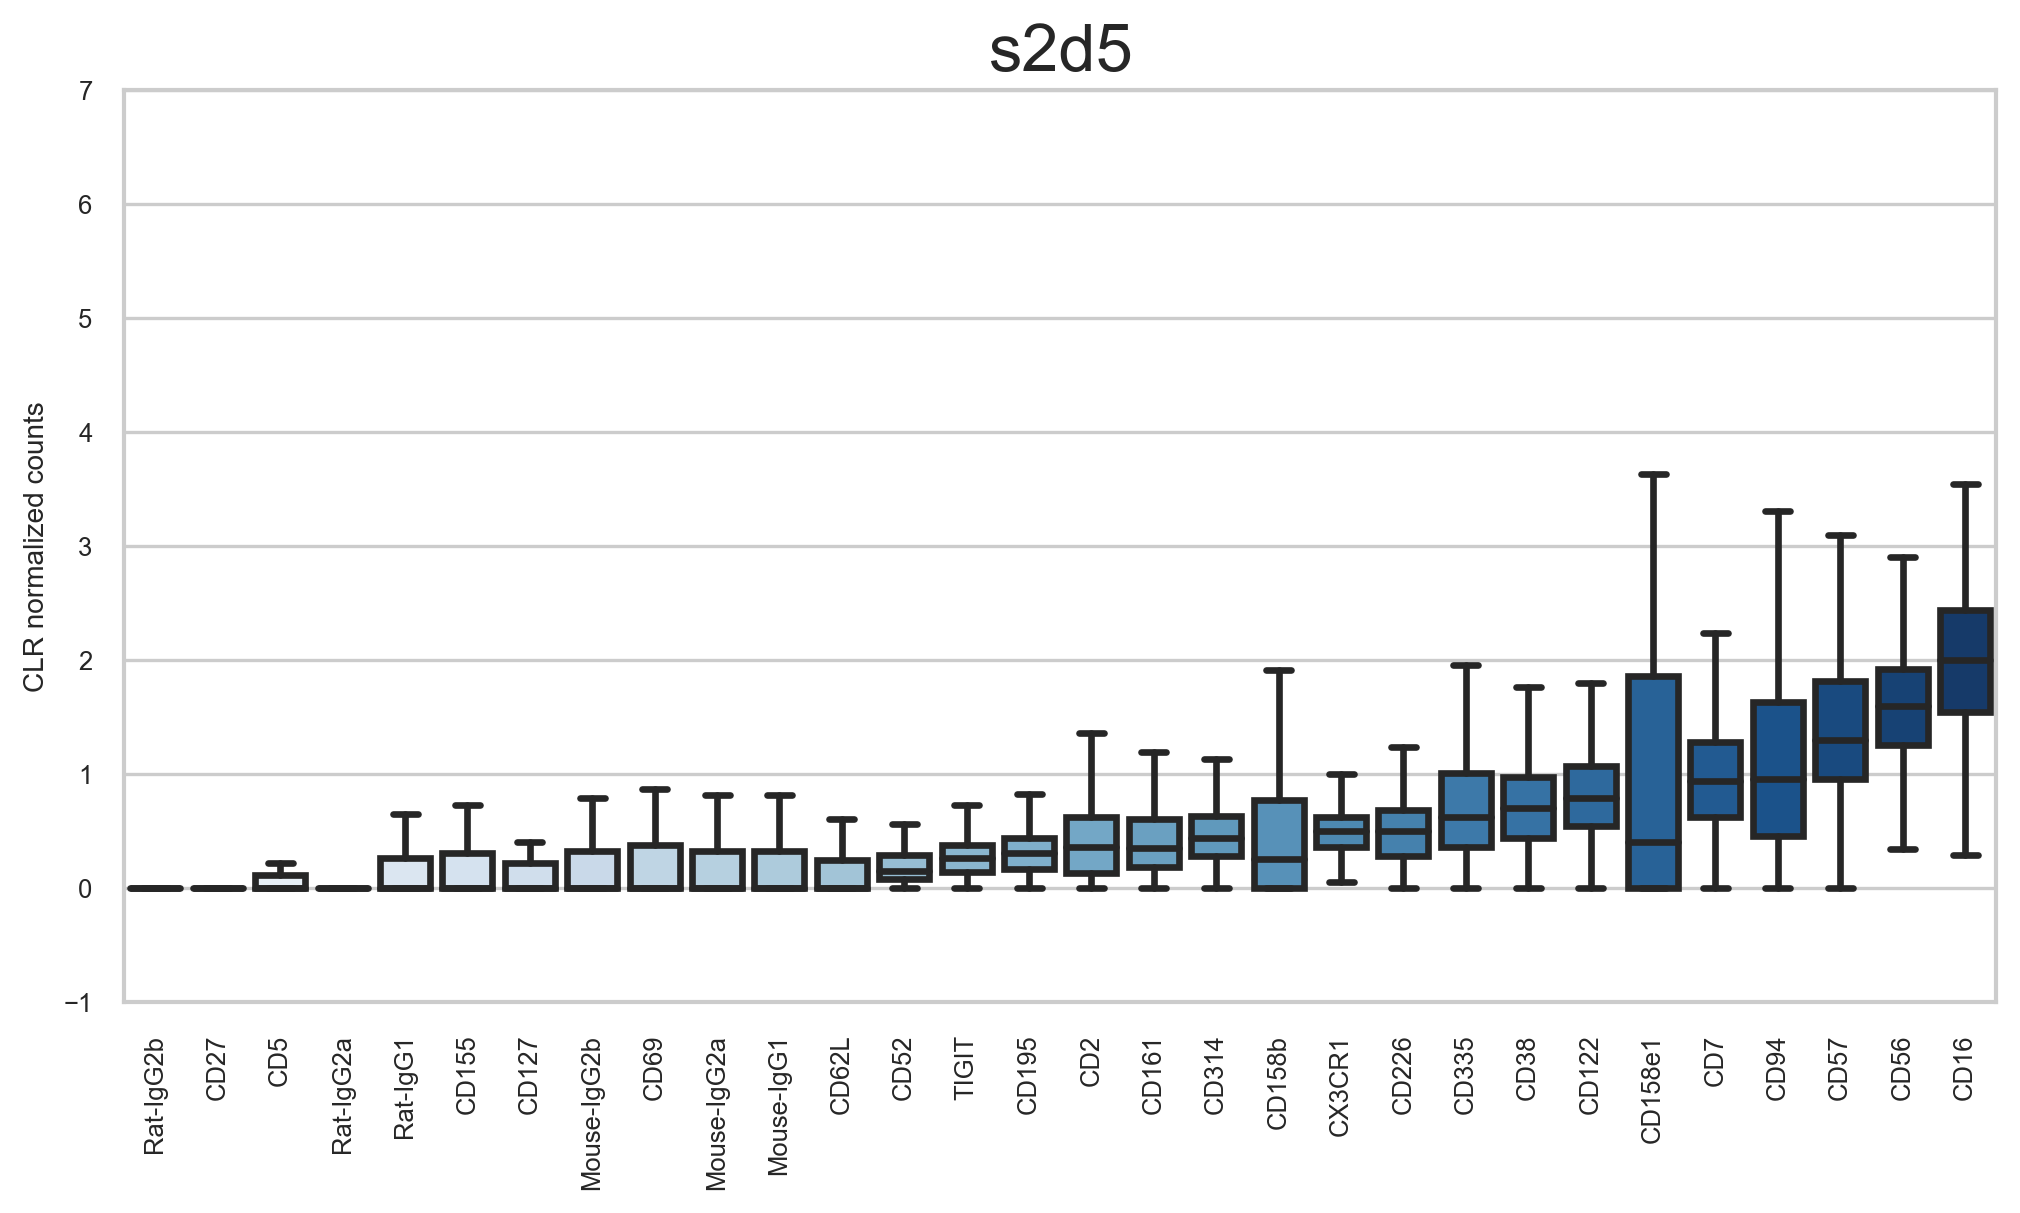

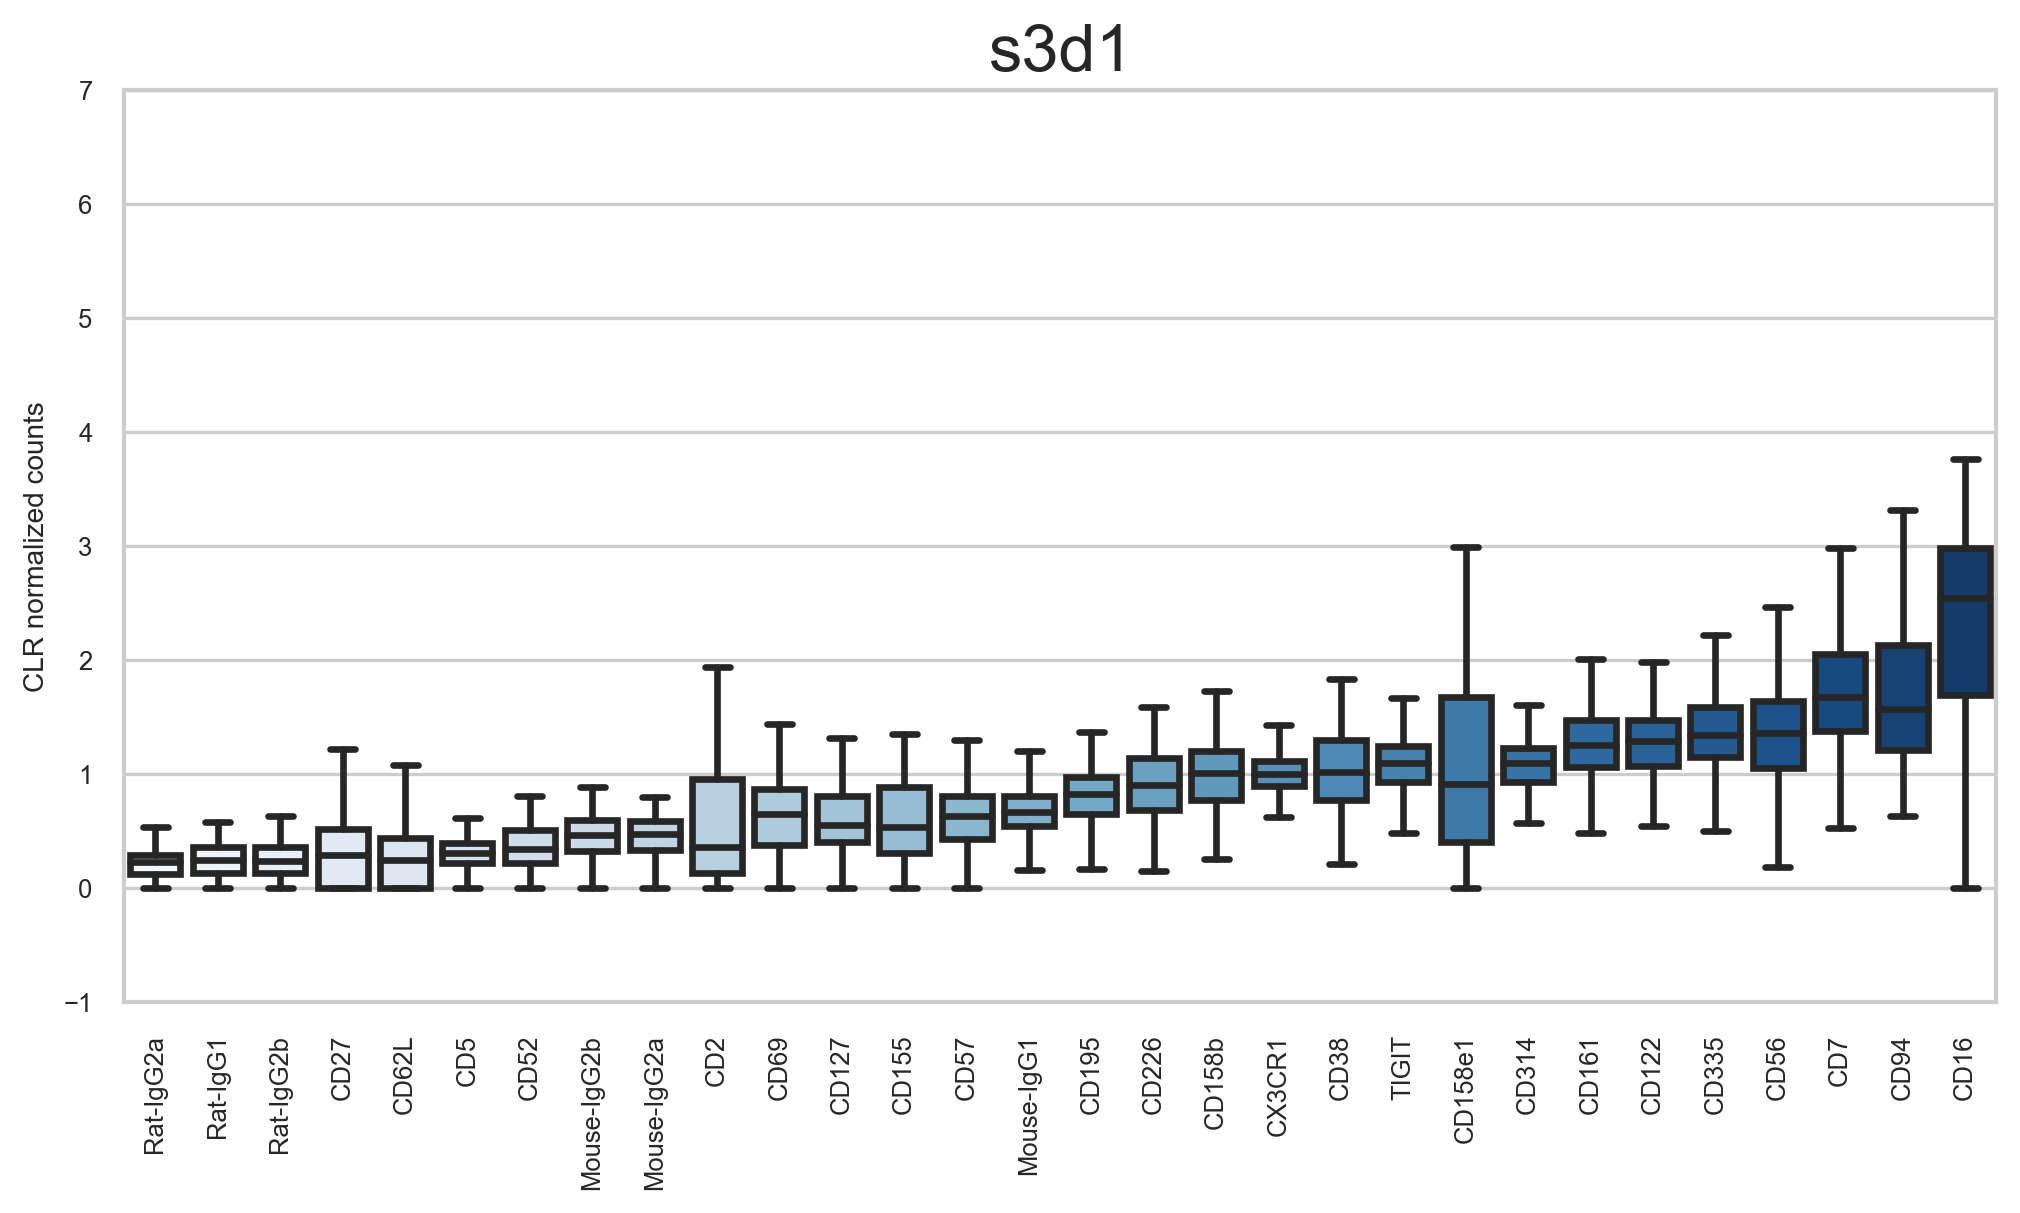

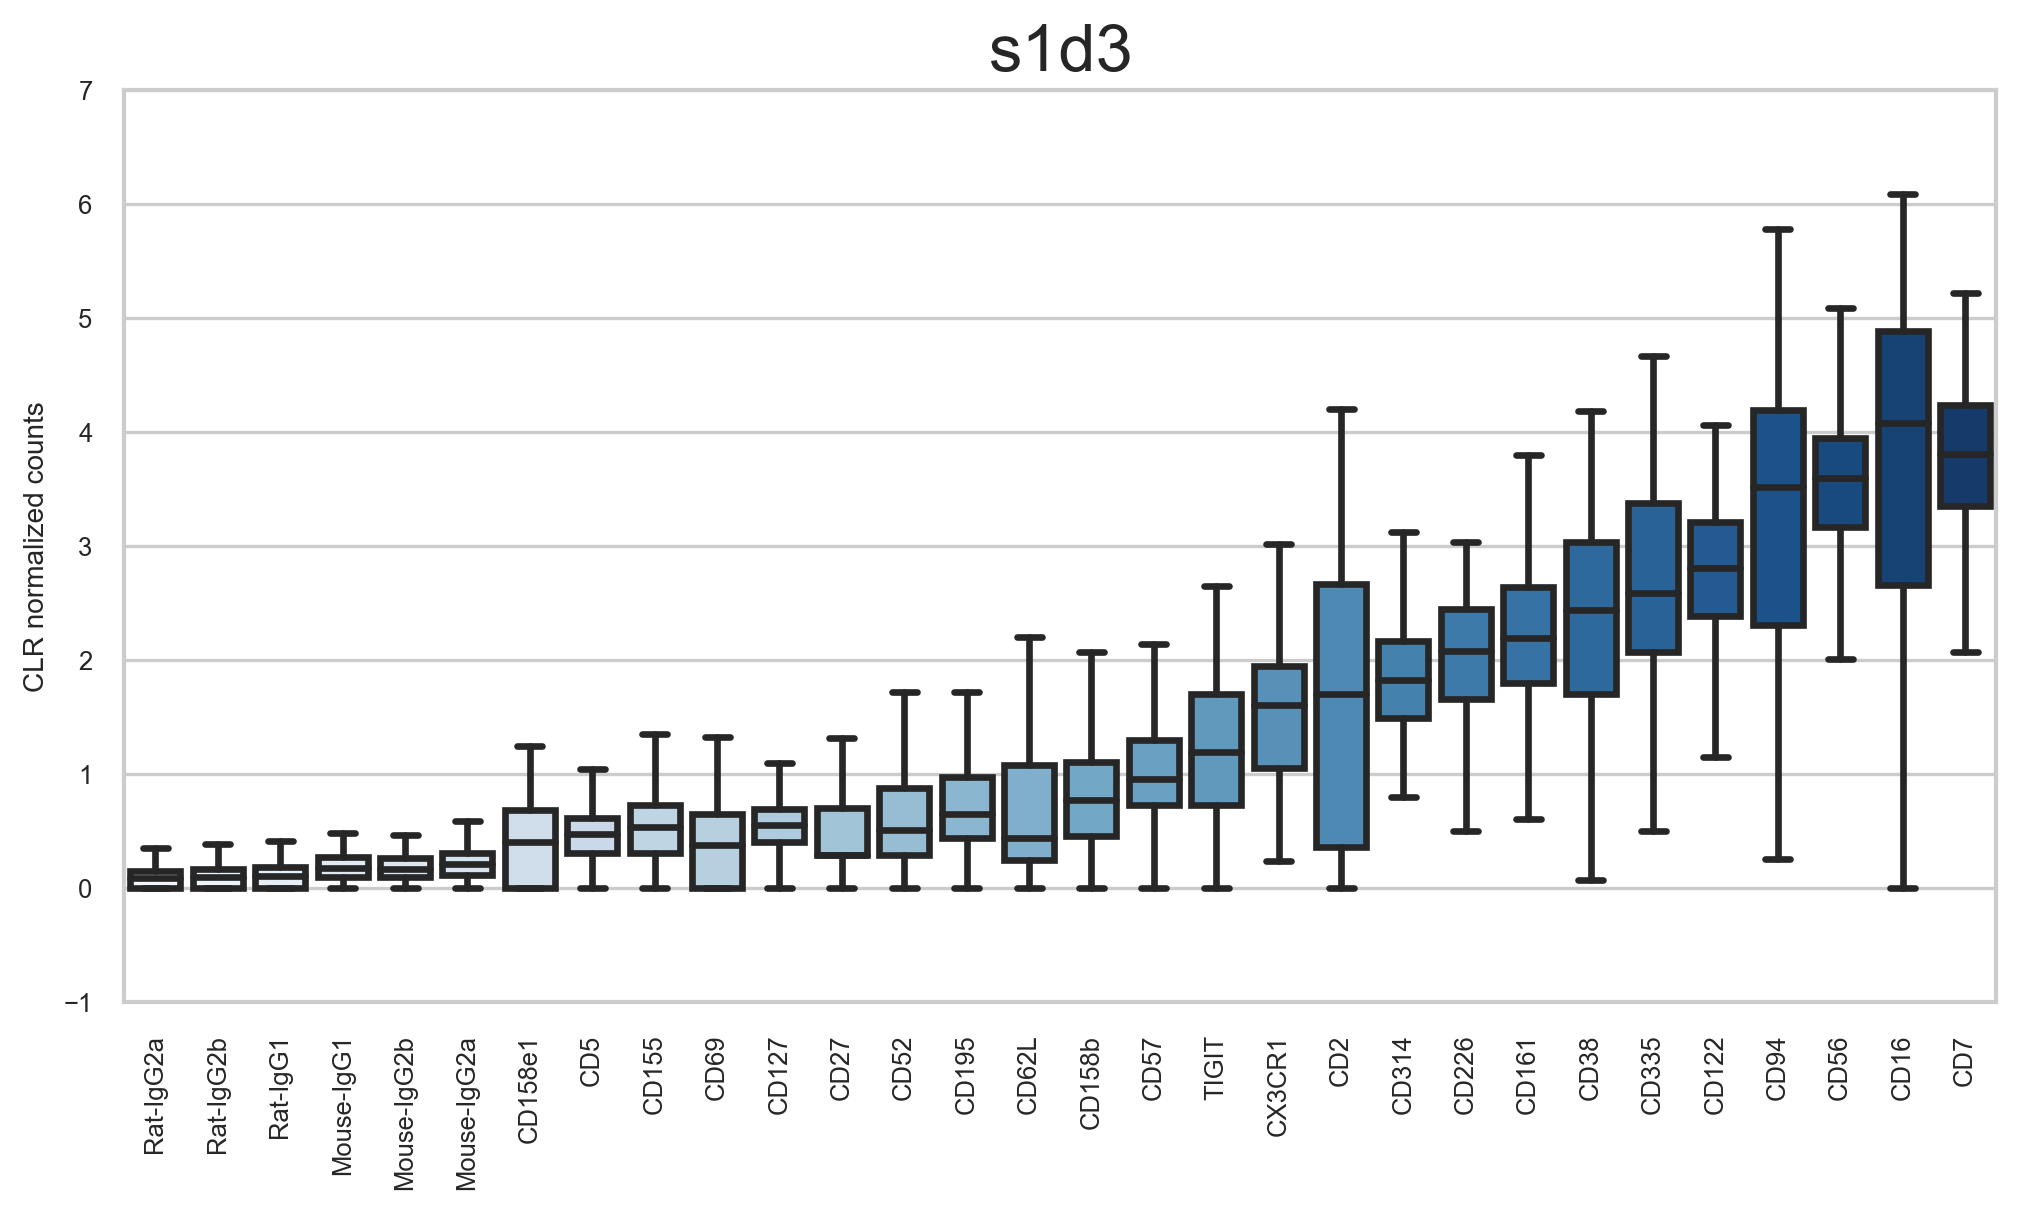

In [74]:
plt.figure(figsize=[10,5])

for sample in samples:
    eg=df[df['Sample'] ==  sample]
    index_sort = eg.mean().sort_values().index
    eg_sorted = eg[index_sort]
    plt.figure(figsize=[10,5])
    b=sns.boxplot(data=eg_sorted, fliersize=0, palette="Blues", linewidth=2) 
    b.set_xticklabels(b.get_xticklabels(),rotation=90) 
    b.set(ylabel= "CLR normalized counts")
    plt.title(sample, fontsize=20)
    plt.ylim(-1, 7)
    plt.show()

In [75]:
#only markers of interest selected

some_markers = ['CD56', 'CD57', 'CD62L', 'CD7', 'CD16', 'CD94']
plot_markers = [some_markers, isotype_col]


list(np.concatenate(plot_markers).flat)


['CD56',
 'CD57',
 'CD62L',
 'CD7',
 'CD16',
 'CD94',
 'Mouse-IgG1',
 'Mouse-IgG2a',
 'Mouse-IgG2b',
 'Rat-IgG2b',
 'Rat-IgG1',
 'Rat-IgG2a']

In [76]:
df_new = df[['CD56',
 'CD57',
 'CD62L',
 'CD7',
 'CD16',
 'CD94',
 'Mouse-IgG1',
 'Mouse-IgG2a',
 'Mouse-IgG2b',
 'Rat-IgG2b',
 'Rat-IgG1',
 'Rat-IgG2a',
 'Sample'
             ]]

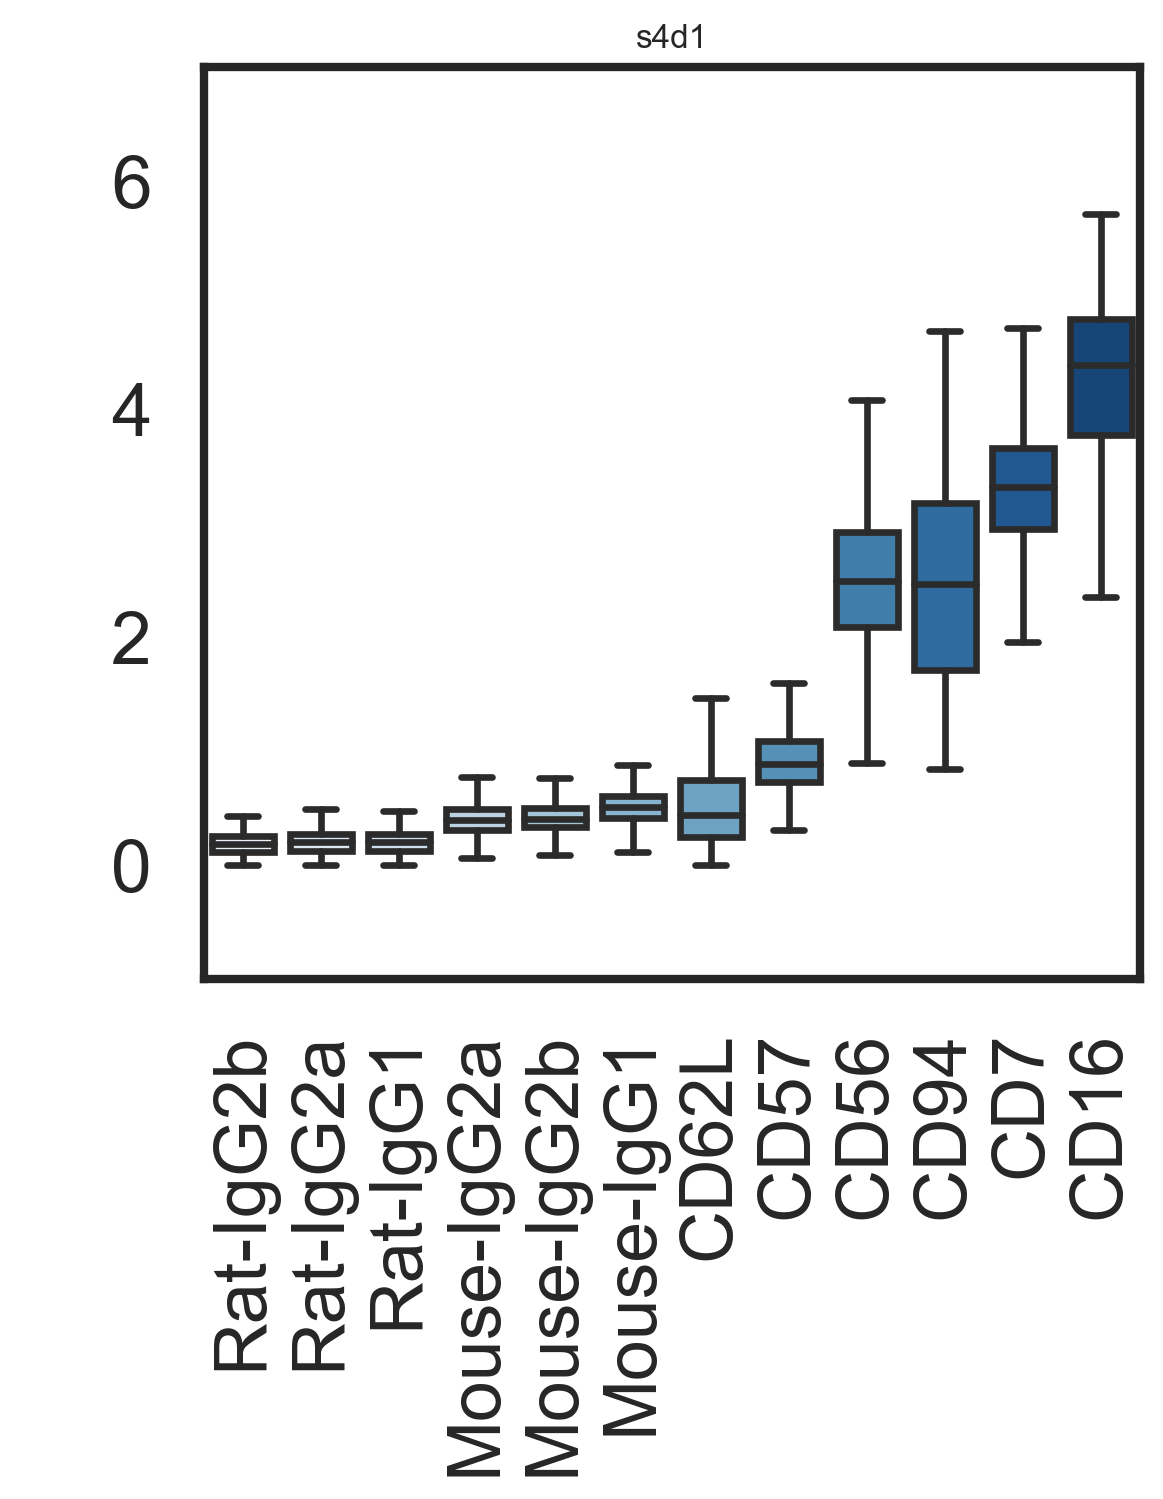

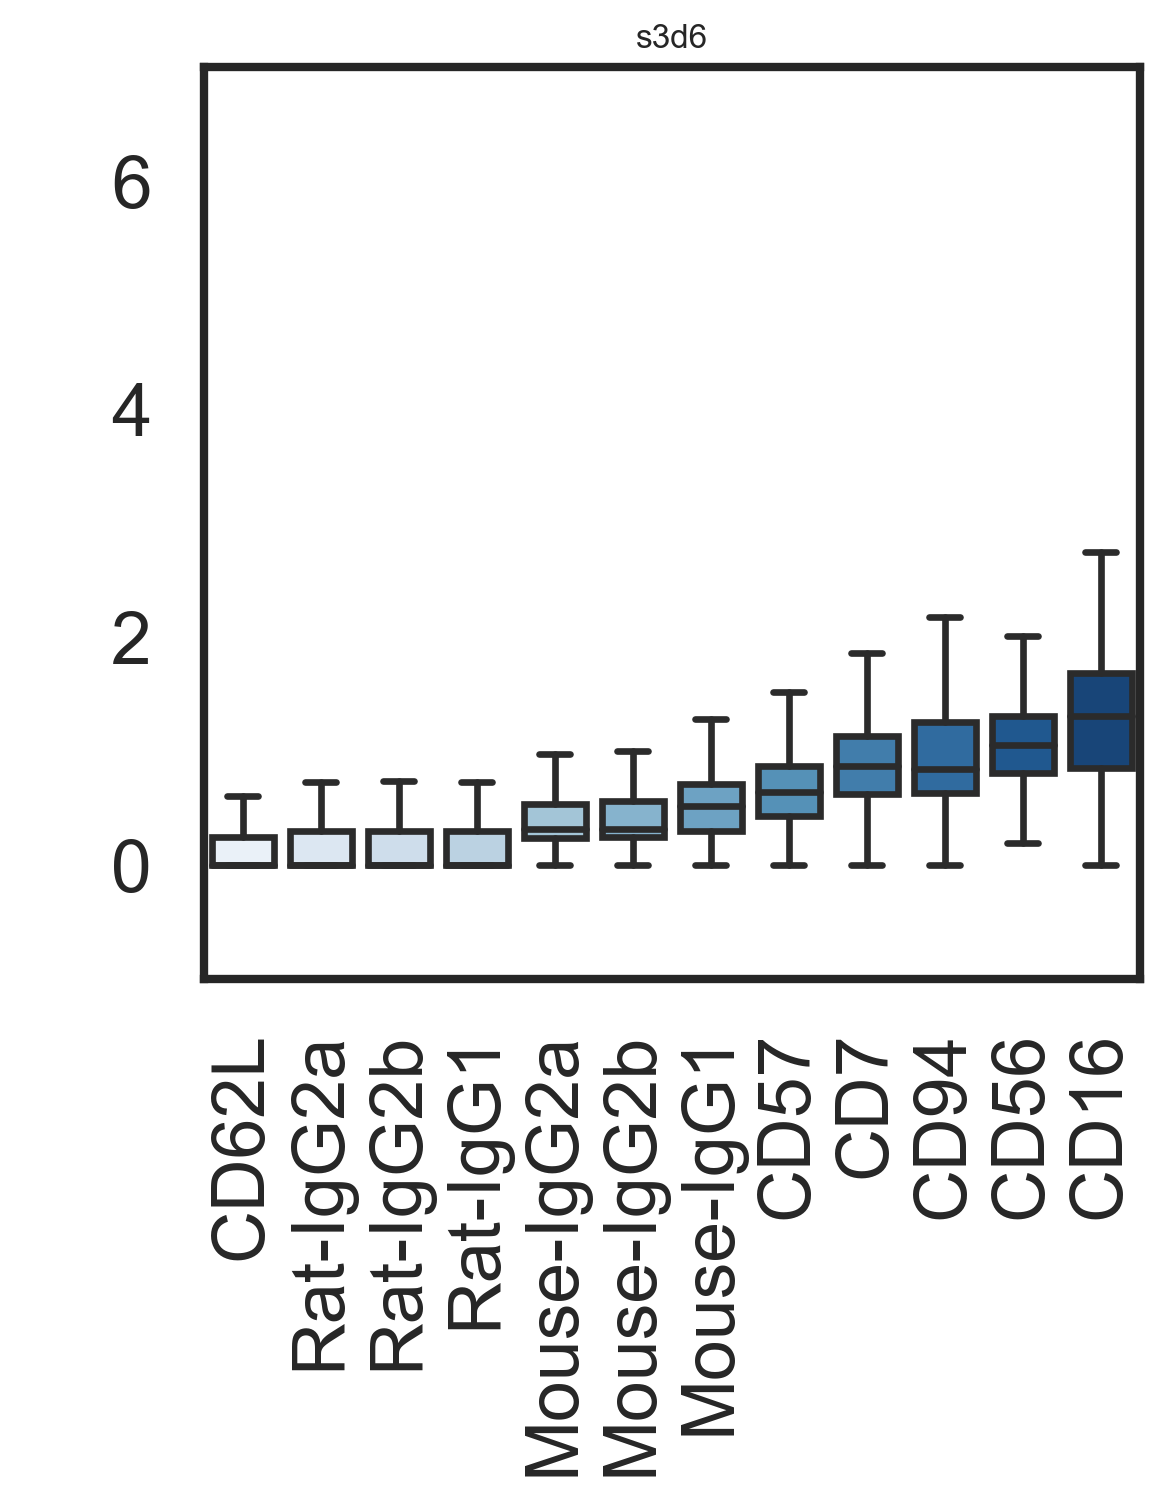

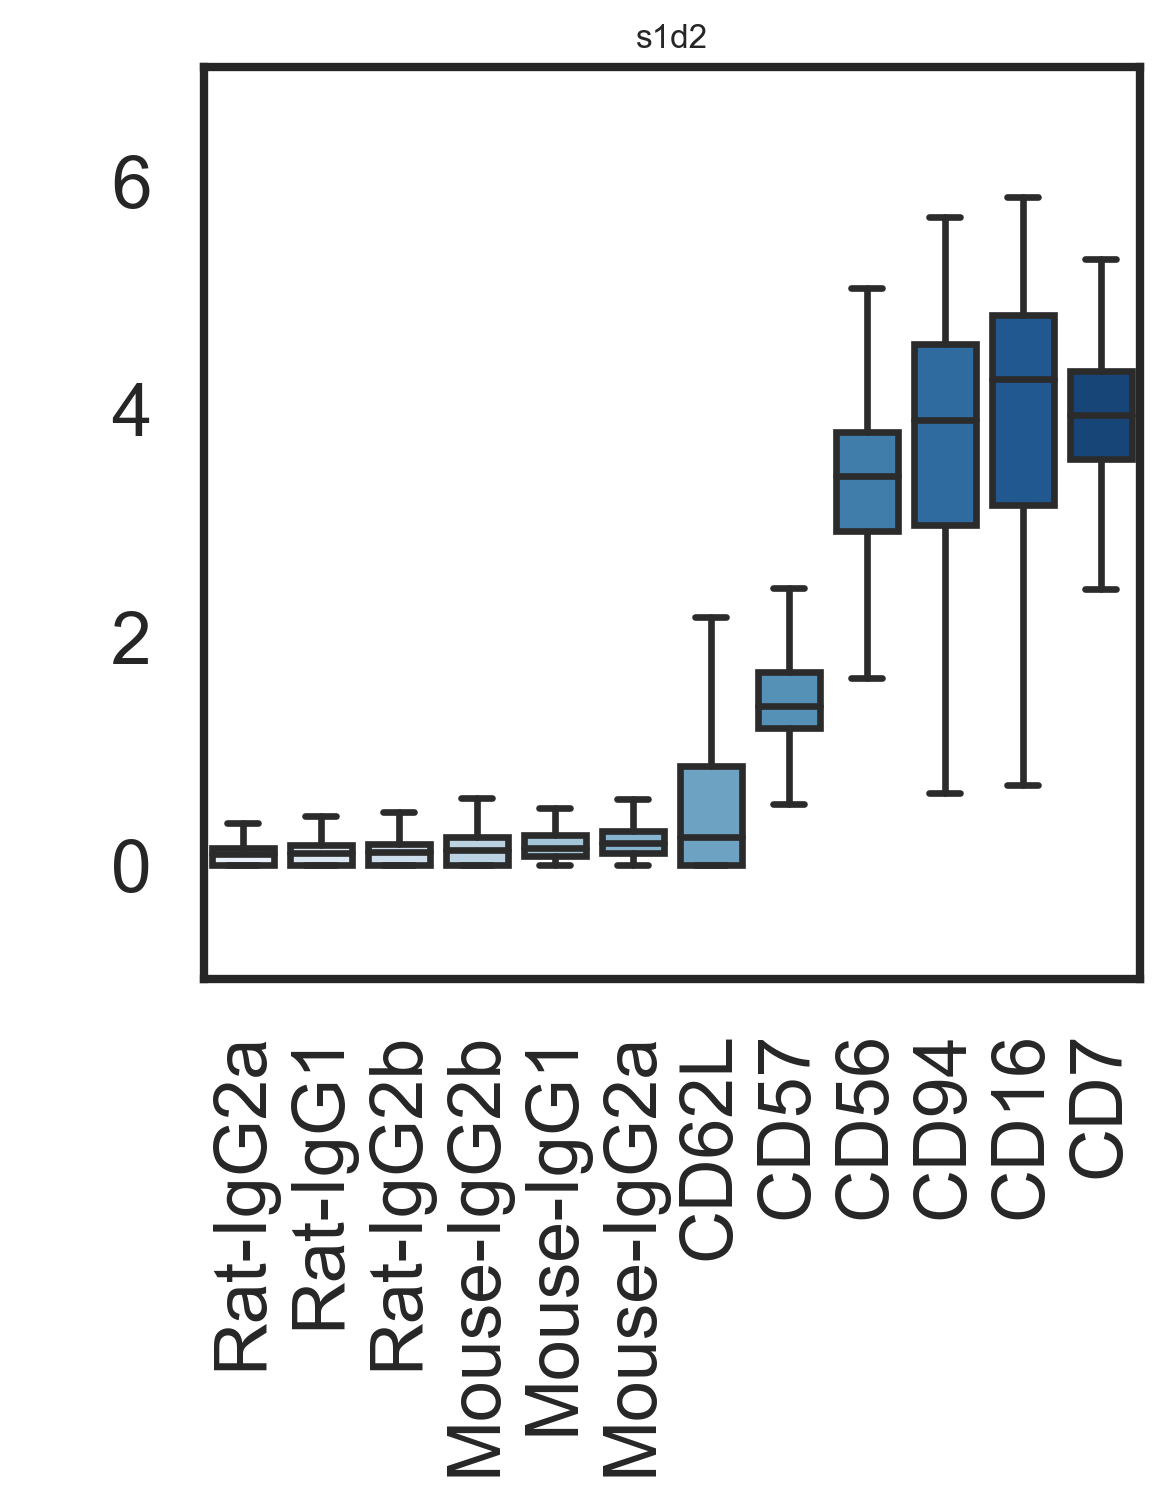

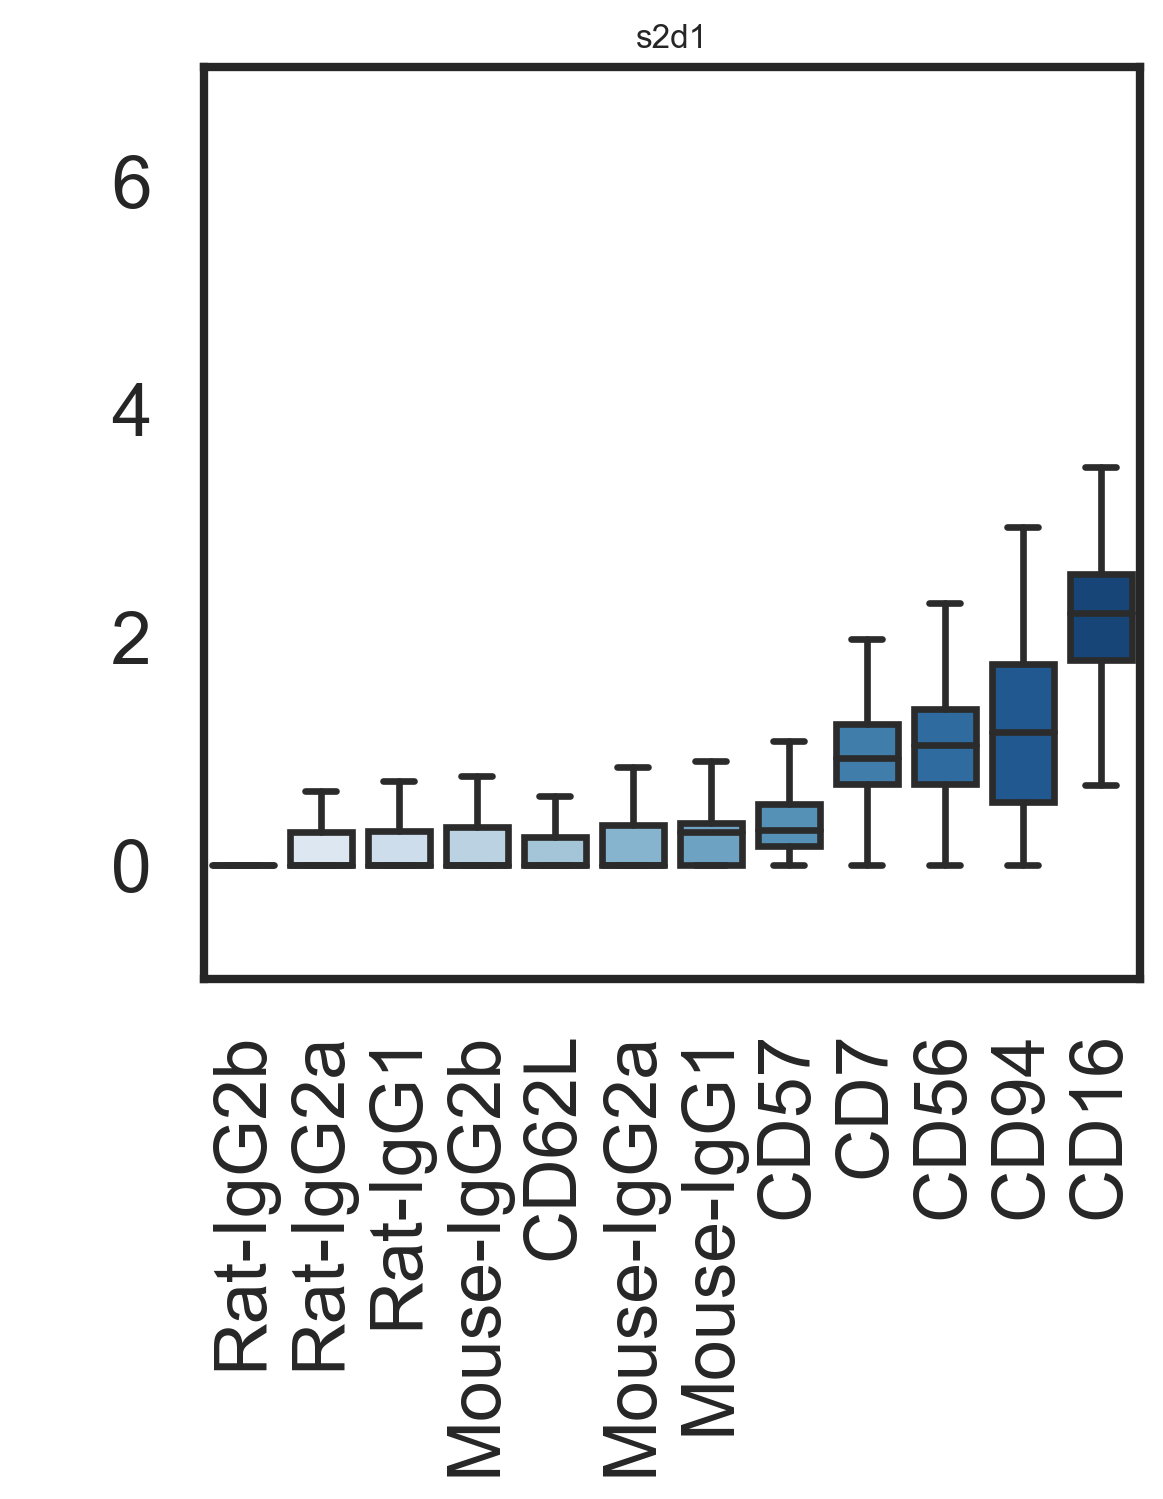

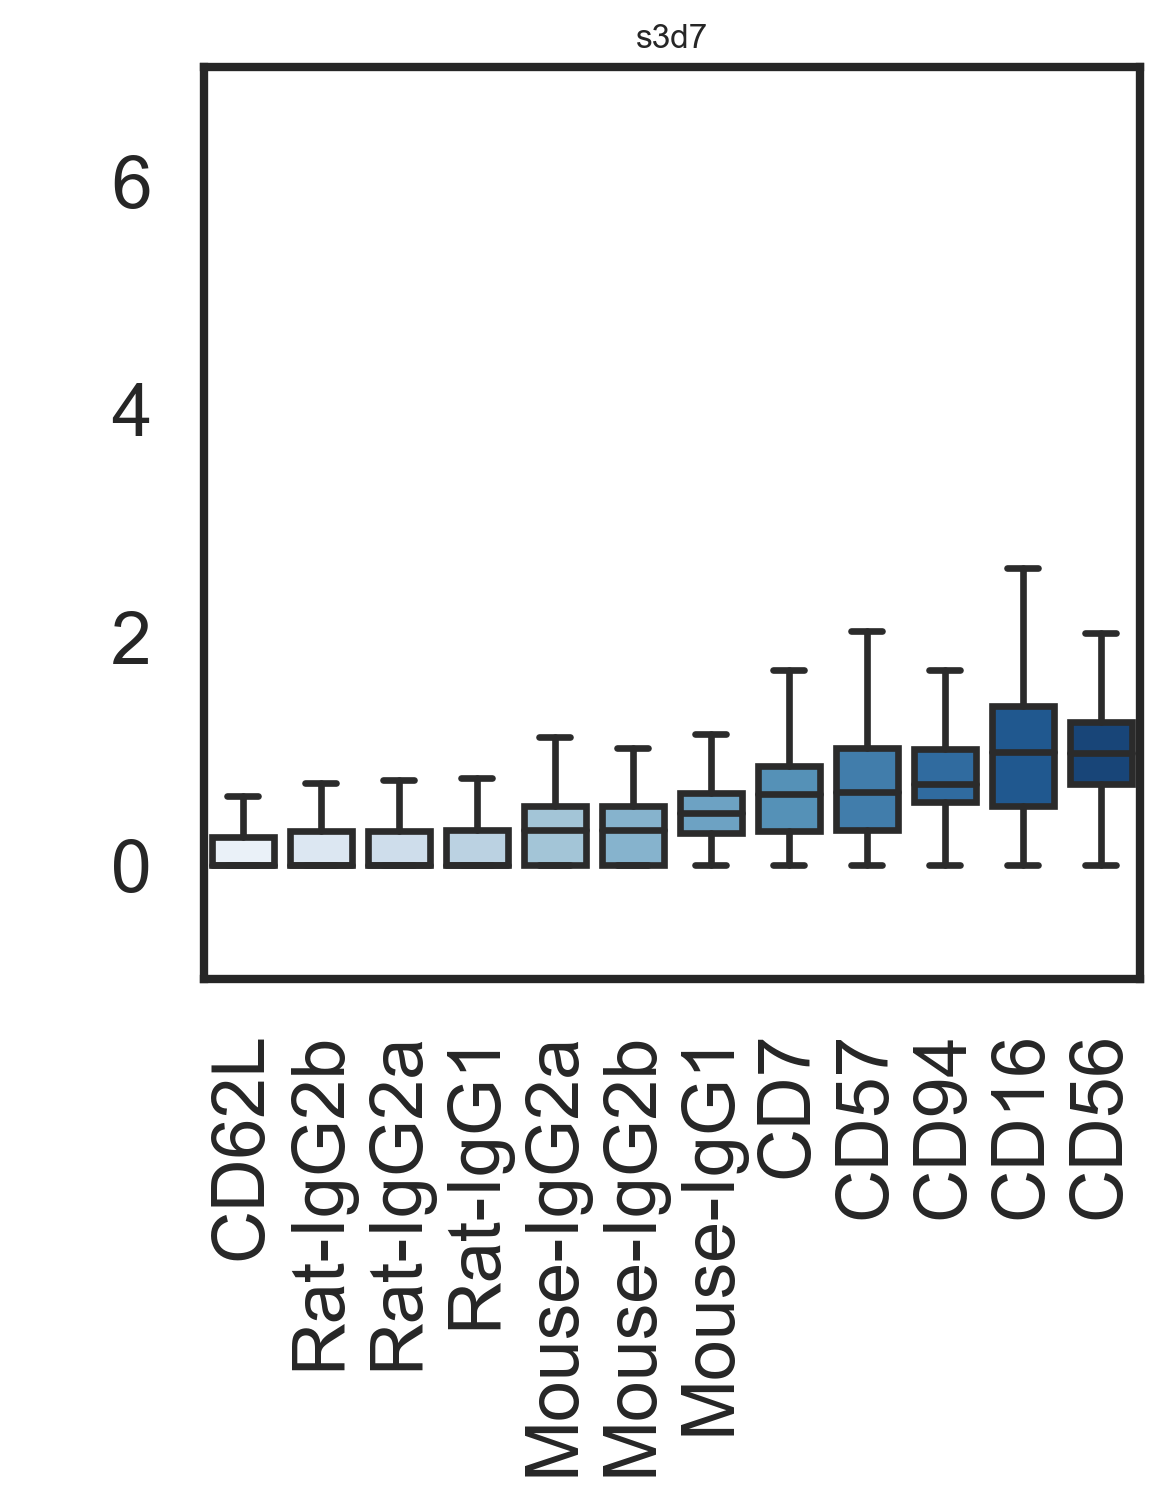

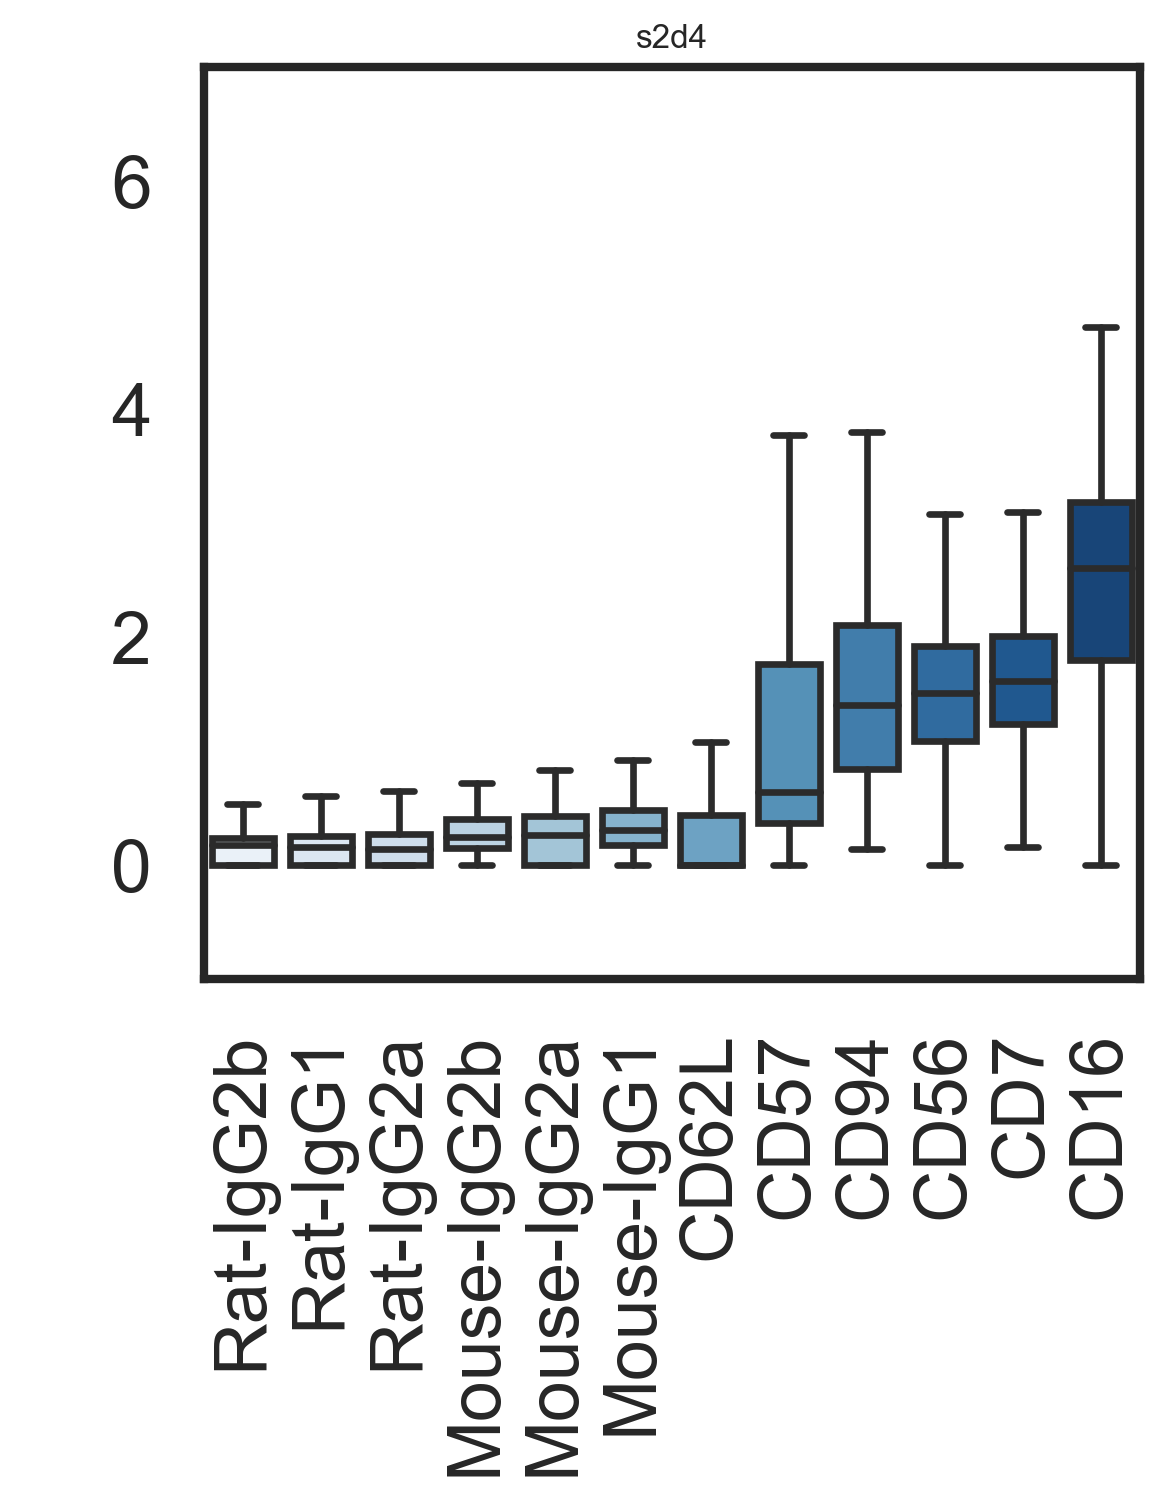

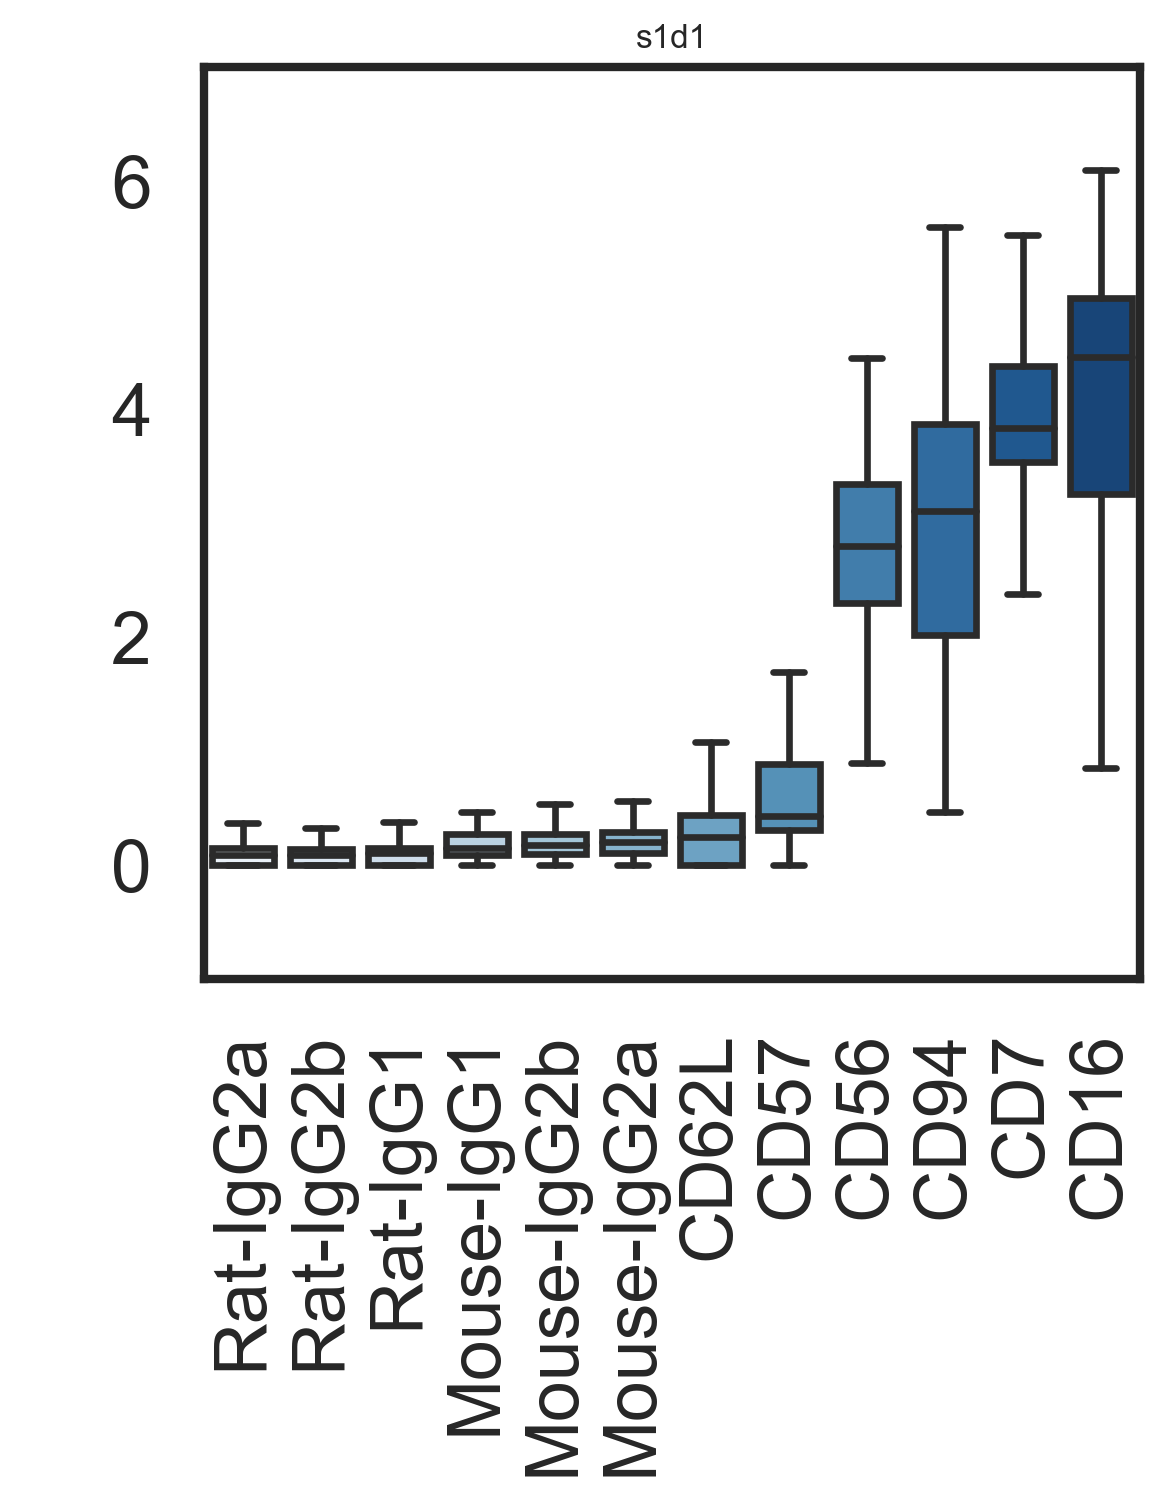

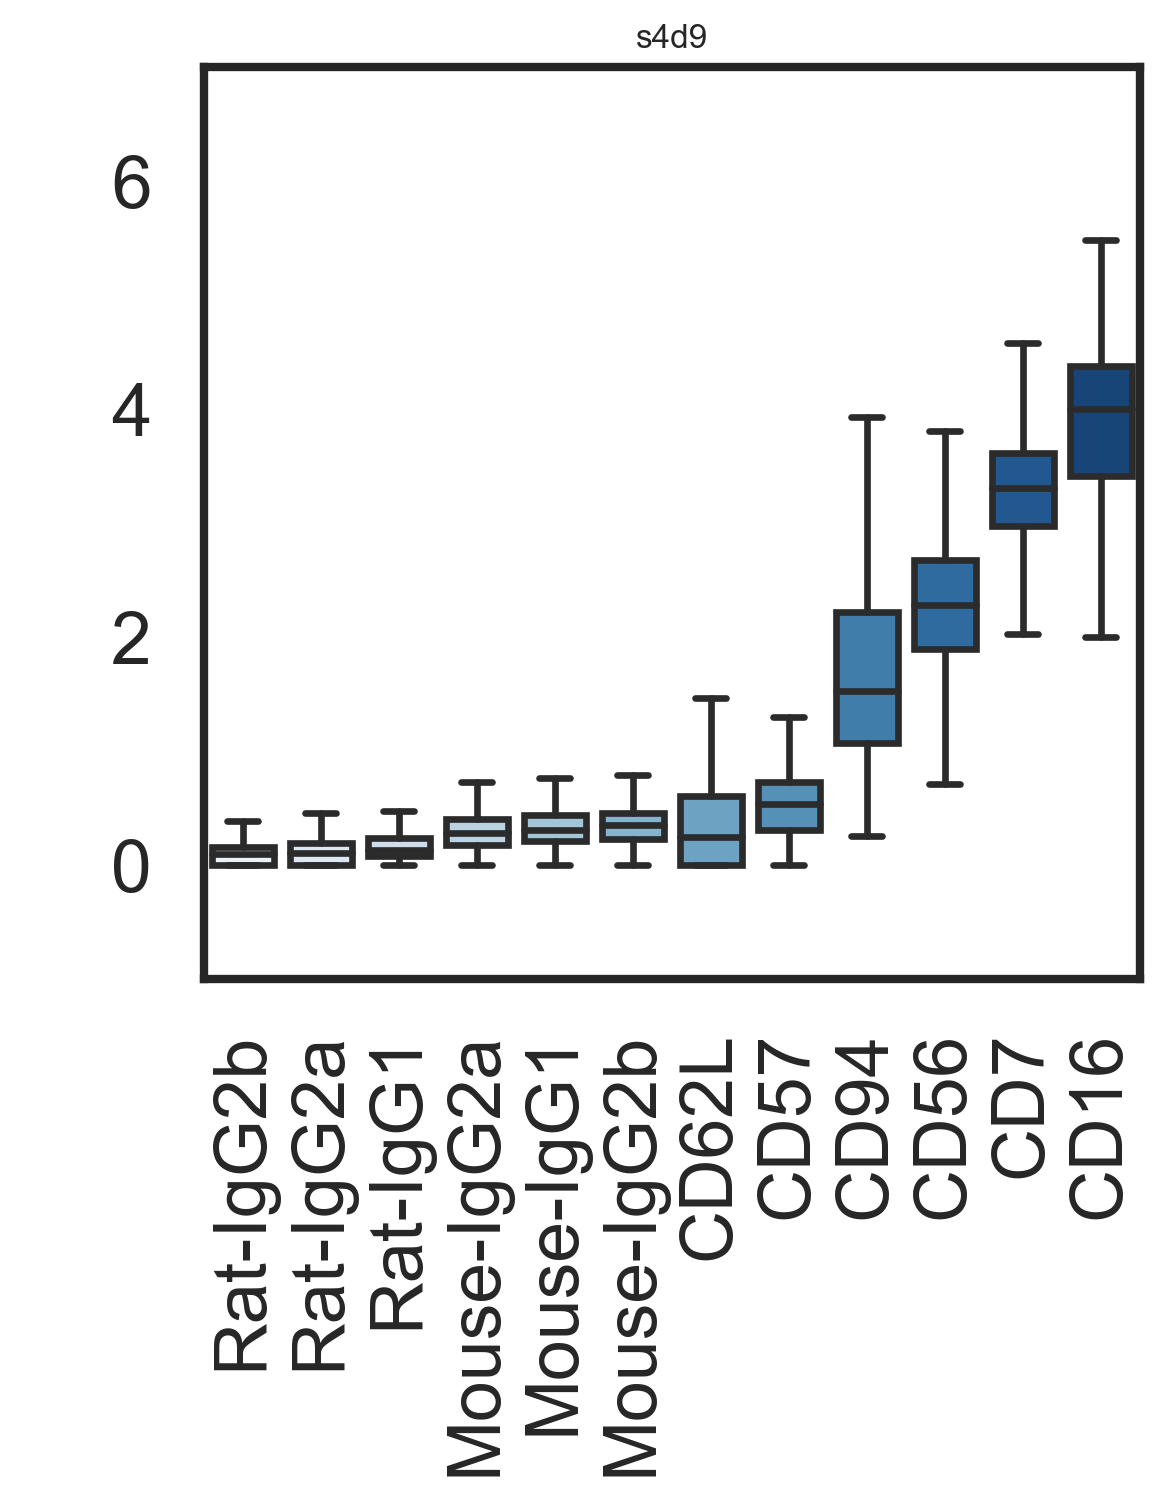

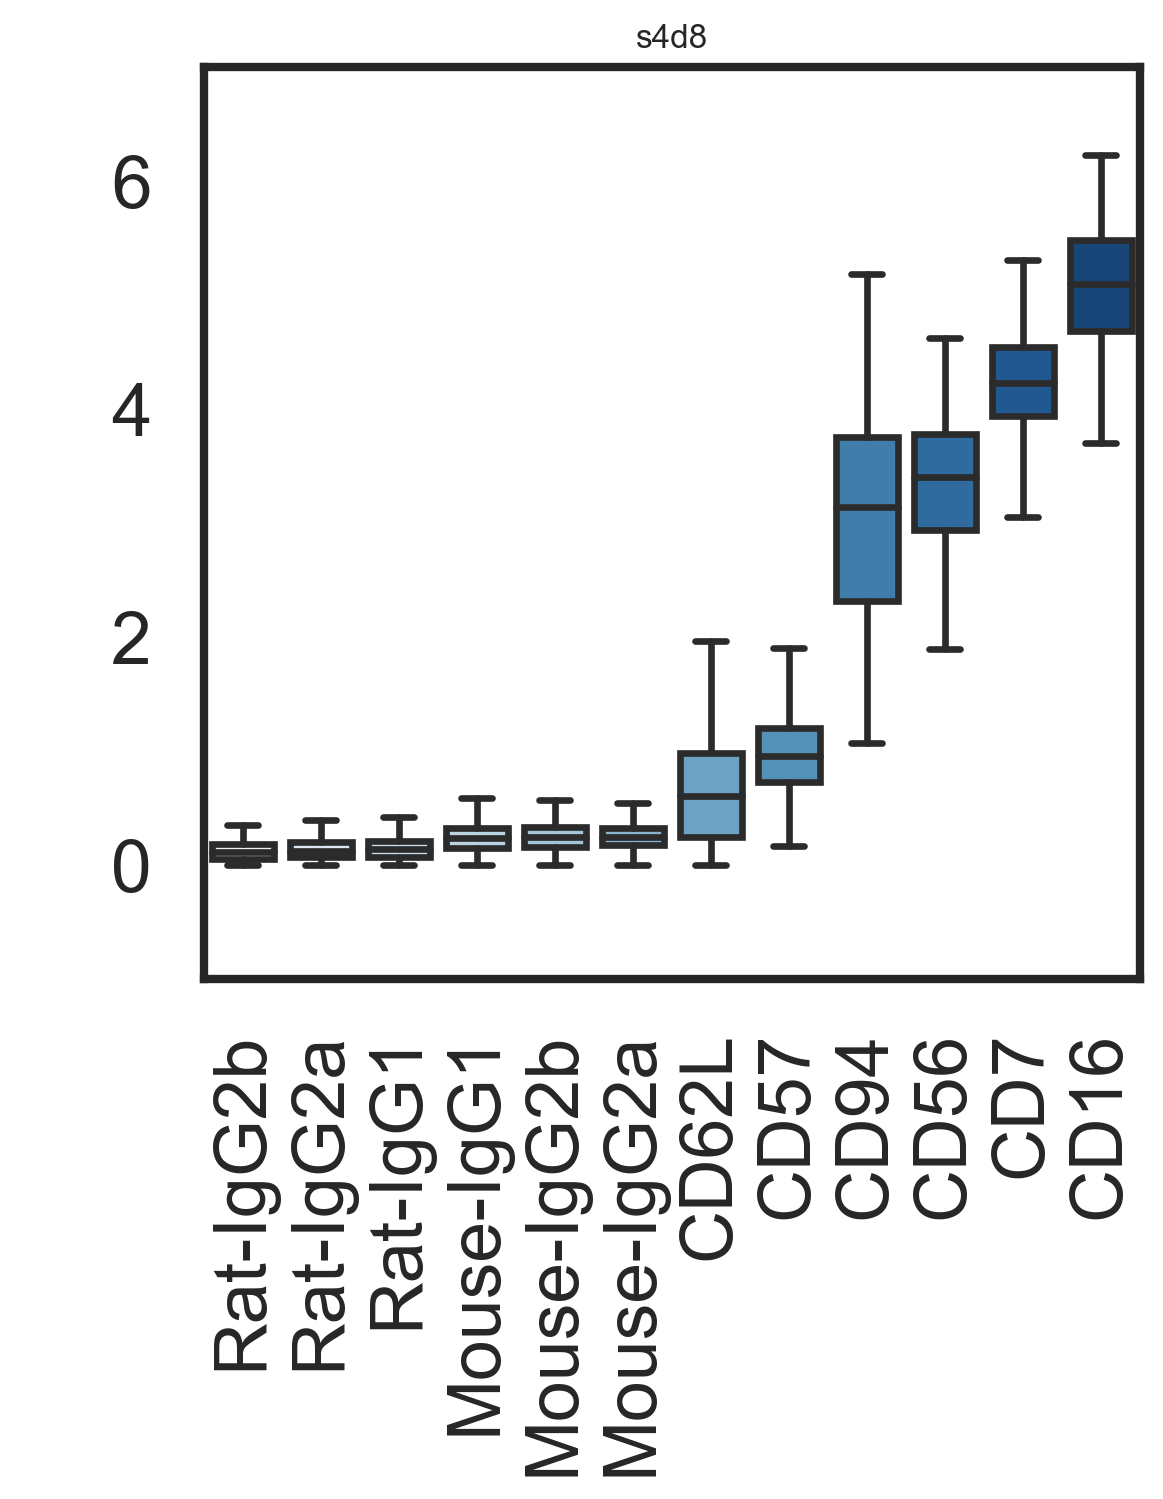

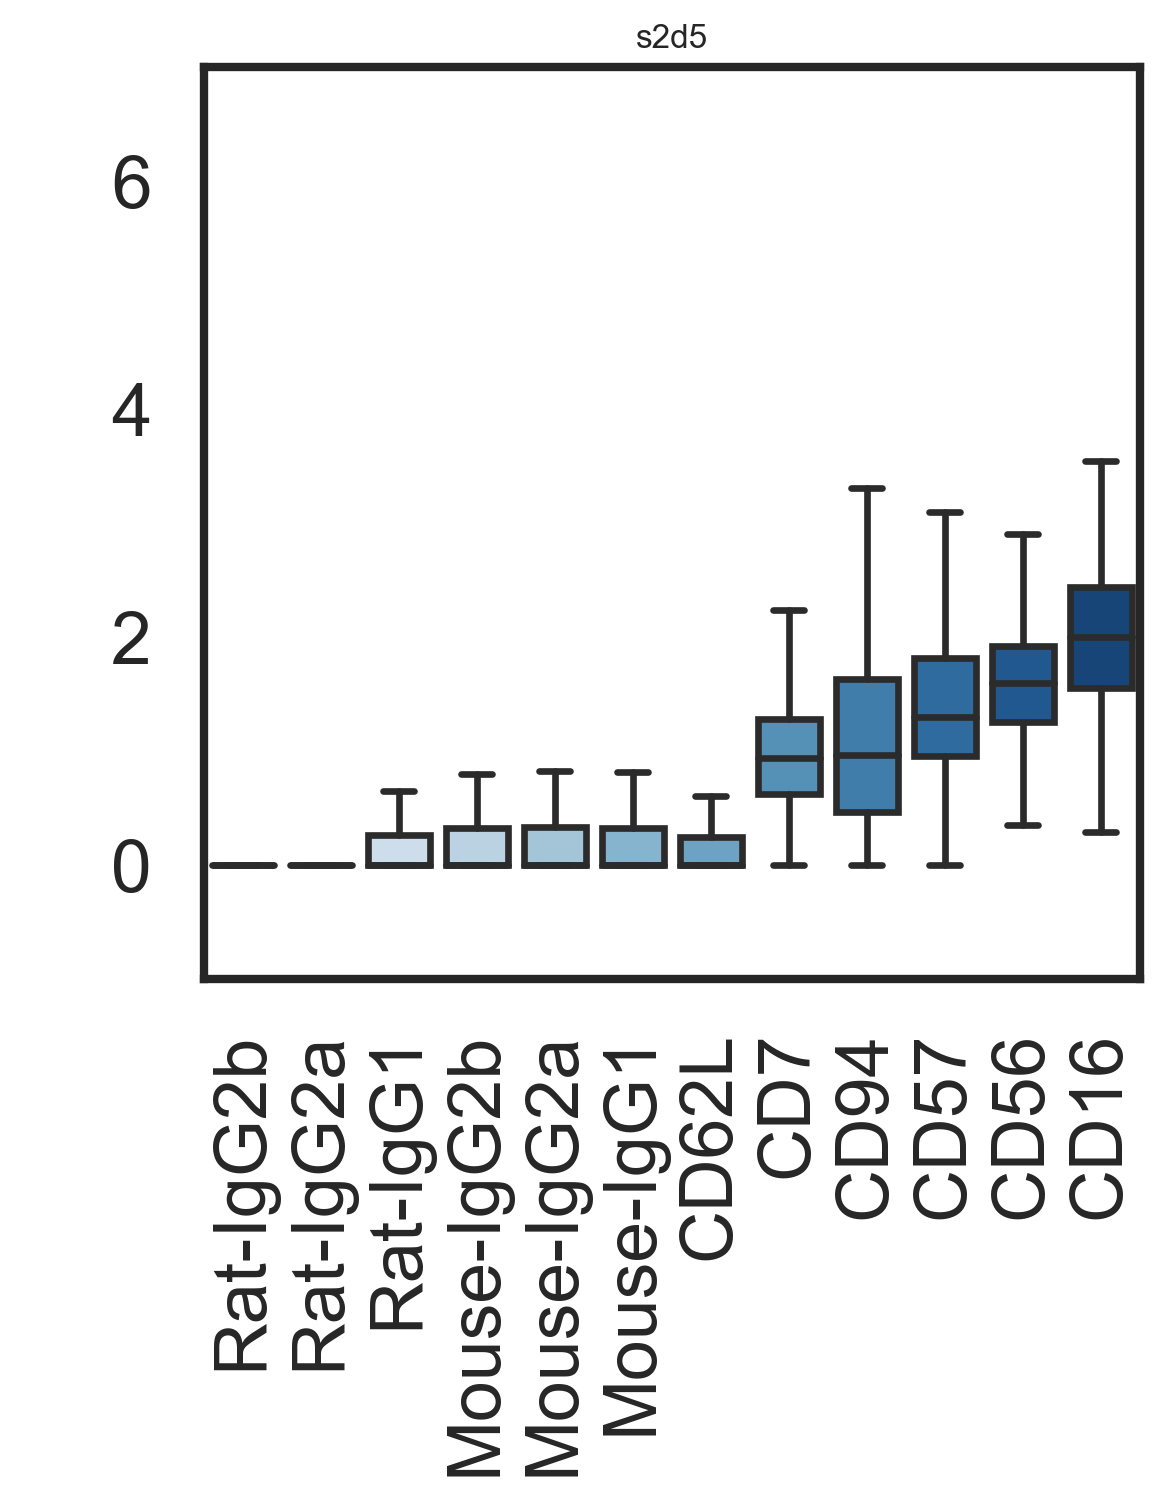

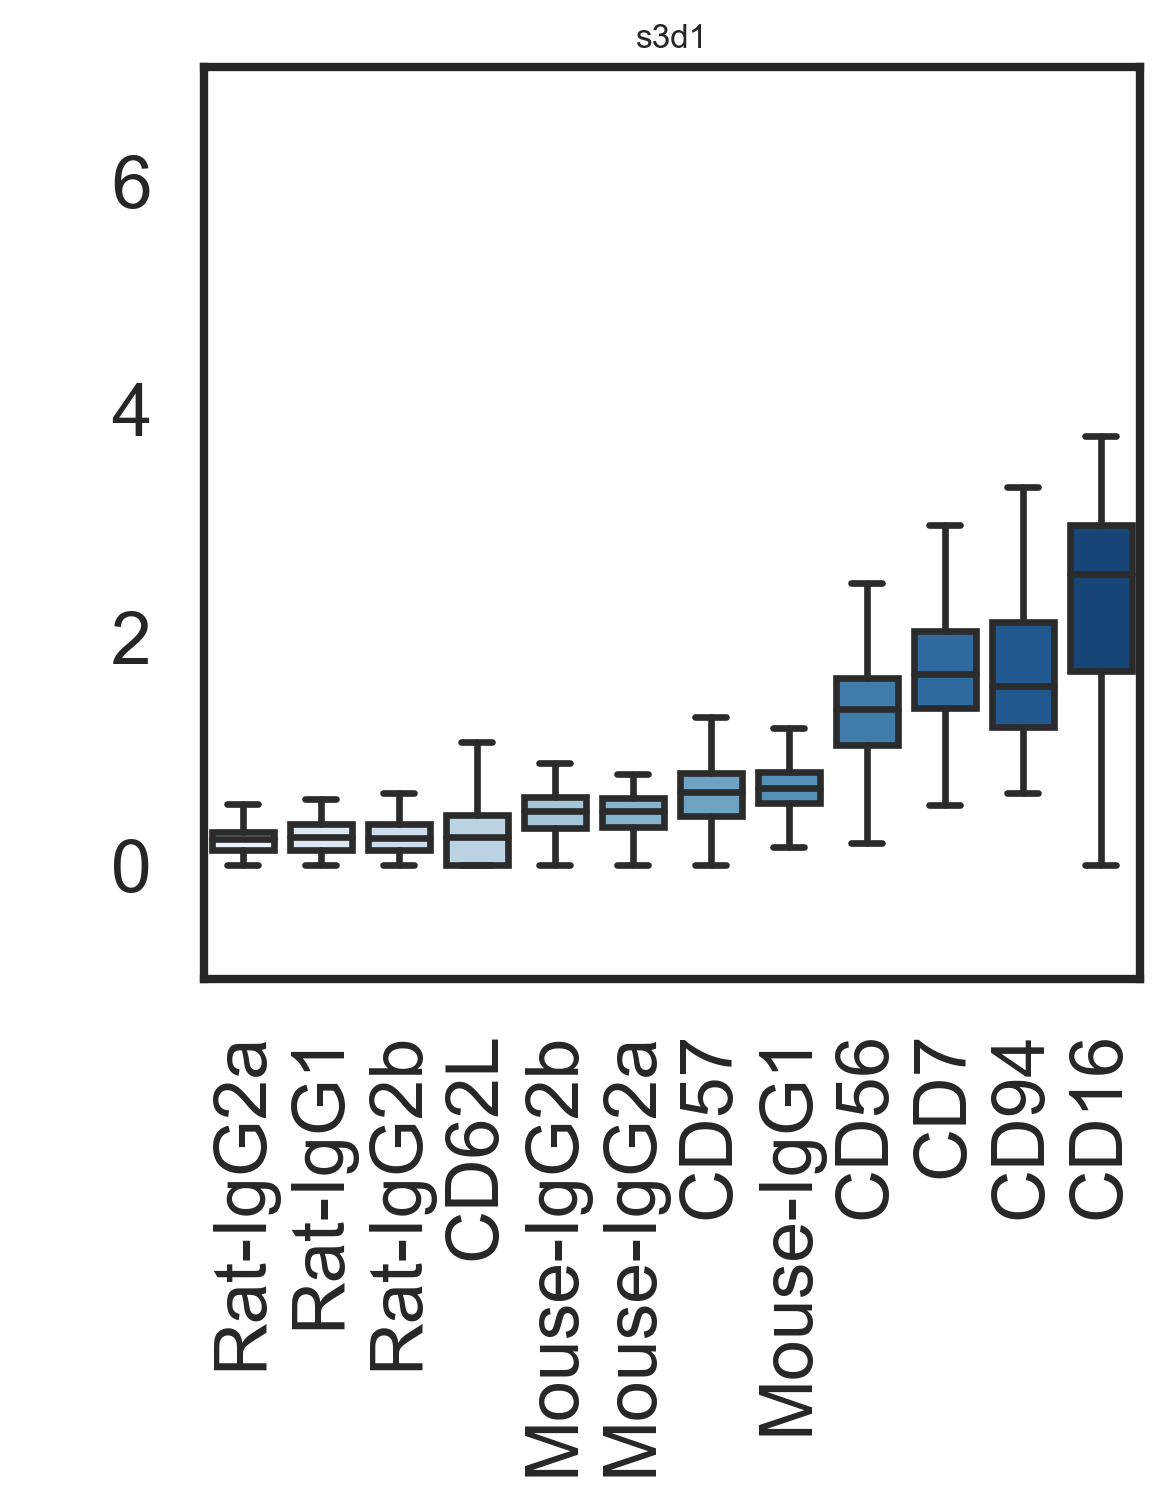

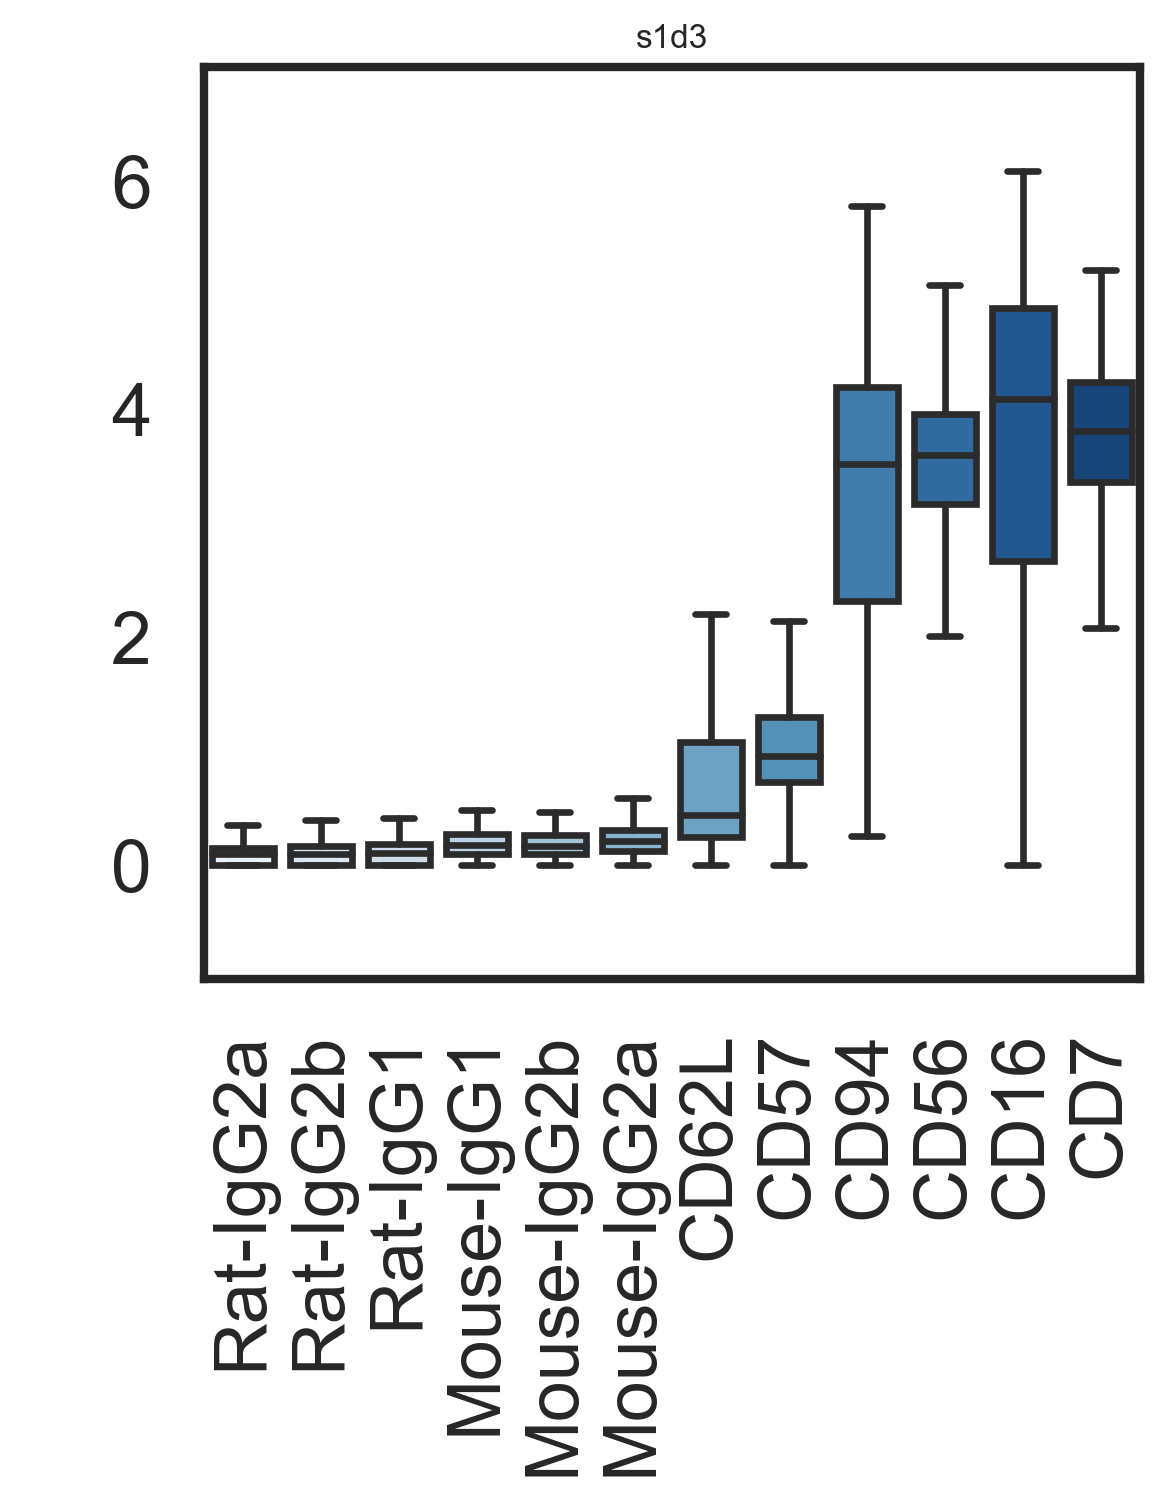

In [82]:
#Same plots but only the most important markers selected

sns.set(style='white',font_scale = 1, context='poster', rc={'figure.figsize':(7,5)})


for sample in samples:
    eg=df_new[df_new['Sample'] ==  sample]
    index_sort = eg.mean().sort_values().index
    eg_sorted = eg[index_sort]
    plt.figure(figsize=[5,5])
    b=sns.boxplot(data=eg_sorted, fliersize=0, palette="Blues", linewidth=2) 
    b.set_xticklabels(b.get_xticklabels(),rotation=90) 
    b.set(ylabel= " ")
    plt.title(sample, fontsize=10)
    plt.ylim(-1, 7)
    plt.show()